# Analisis Exploratorio de los Datos.

### **Idea general de nuestro analisis :**
Nuestro analisis exploratorio se centra en responder a una cuestion, ¿Podemos predecir quien estaría interesado en comprar una poliza de seguro de caravana?

### **Variable objetivo del dataset :** 
"CARAVAN" : Numero de polizas de caravanas o casas moviles. 

## Importación de las librerias a utilizar

Aqui se importan las librerias que seran necesarias para el analisis a realizar.

In [6]:
#IMPORTAR LIBRERIA

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
from matplotlib.pyplot import *
from sklearn.impute import KNNImputer
import scipy.stats as ss
import warnings

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

## Creación de funciones

Se cargan algunas funciones a utilizar que nos ayudan en el futuro analisis de los datos.

In [2]:
# # Esta funcion se encarga de identificar las variables categoricas y colocarlas dentro de una lista especifica. Las 
# #variables que se muestran como numericas se recopilan en otra lista.
def dame_variables_categoricas(dataset=None):
    if dataset is None:
        print(u'\nFaltan argumentos por pasar a la función')
        return 1
    lista_variables_categoricas = []
    other = []
    for i in dataset.columns:
        if (dataset[i].dtype!=float) & (dataset[i].dtype!=int):
            unicos = int(len(np.unique(dataset[i].dropna(axis=0, how='all'))))
            if unicos < 100:
                lista_variables_categoricas.append(i)
            else:
                other.append(i)

    return lista_variables_categoricas, other

# Esta funcion ayuda al momento de visualizacion de las diferentes variables dentro del dataset para poder comparar en base 
#la funcion objetivo como es el comportamiento de la demas variables

def plot_feature(df, col_name, isContinuous, target):
    """
    Visualize a variable with and without faceting on the loan status.
    - df dataframe
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    count_null = df[col_name].isnull().sum()
    if isContinuous:
        
        sns.histplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Count')
    ax1.set_title(col_name+ ' Numero de nulos: '+str(count_null))
    plt.xticks(rotation = 90)


    if isContinuous:
        sns.boxplot(x=col_name, y=target, data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(col_name + ' by '+target)
    else:
        data = df.groupby(col_name)[target].value_counts(normalize=True).to_frame('proportion').reset_index() 
        data.columns = [i, target, 'proportion']
        #sns.barplot(x = col_name, y = 'proportion', hue= target, data = data, saturation=1, ax=ax2)
        sns.barplot(x = col_name, y = 'proportion', hue= target, data = data, saturation=1, ax=ax2)
        ax2.set_ylabel(target+' fraction')
        ax2.set_title(target)
        plt.xticks(rotation = 90)
    ax2.set_xlabel(col_name)
    
    plt.tight_layout()

def get_deviation_of_mean_perc(pd_data, list_variables_numericas, target, multiplier):
    """
    Devuelve el porcentaje de valores que exceden del intervalo de confianza
    :type series:
    :param multiplier:
    :return:
    """
    pd_final = pd.DataFrame()
    
    for i in list_variables_numericas:
        
        series_mean = pd_data[i].mean()
        series_std = pd_data[i].std()
        std_amp = multiplier * series_std
        left = series_mean - std_amp
        right = series_mean + std_amp
        size_s = pd_data[i].size
        
        perc_goods = pd_data[i][(pd_data[i] >= left) & (pd_data[i] <= right)].size/size_s
        perc_excess = pd_data[i][(pd_data[i] < left) | (pd_data[i] > right)].size/size_s
        
        if perc_excess>0:    
            pd_concat_percent = pd.DataFrame(pd_data[target][(pd_data[i] < left) | (pd_data[i] > right)]\
                                            .value_counts(normalize=True).reset_index()).T
            pd_concat_percent.columns = [pd_concat_percent.iloc[0:], 
                                          pd_concat_percent.iloc[0:]]
            pd_concat_percent = pd_concat_percent.drop('index',axis=0)
            pd_concat_percent['variable'] = i
            pd_concat_percent['sum_outlier_values'] = pd_data[i][(pd_data[i] < left) | (pd_data[i] > right)].size
            pd_concat_percent['porcentaje_sum_null_values'] = perc_excess
            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(drop=True)
            
    if pd_final.empty:
        print('No existen variables con valores nulos')
        
    return pd_final


def get_corr_matrix(dataset = None, metodo='pearson', size_figure=[10,8]):
    # Para obtener la correlación de Spearman, sólo cambiar el metodo por 'spearman'

    if dataset is None:
        print(u'\nHace falta pasar argumentos a la función')
        return 1
    sns.set(style="white")
    # Compute the correlation matrix
    corr = dataset.corr(method=metodo) 
    # Set self-correlation to zero to avoid distraction
    for i in range(corr.shape[0]):
        corr.iloc[i, i] = 0
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=size_figure)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, center=0,
                square=True, linewidths=.5,  cmap ='viridis' ) #cbar_kws={"shrink": .5}
    plt.show()
    
    return 0

## Creacion de dataframes y verificacion de los datos a analizar dentro de los dataframes

Creamos un dataframe el cual tiene el conjunto de datos que se van a utilizar para training y por otra parte, realizamos una asignación de manera "manual" con el nombre de cada una de las columnas de los datos de training o entrenamiento.

In [9]:
#Importamos los datos al notebook y comprobamos la dimension de nuestros datos.
pd_data = pd.read_csv("c:/Users/karla/Desktop/Trabajo_EDA/data/ticdata2000.txt",sep ='\t', header = None)
pd_data.shape

(5822, 86)

In [4]:
#Asignamos el nombre de cada variable a la columna que le corresponde.
pd_data.columns = ([
     "MOSTYPE", "MAANTHUI", "MGEMOMV", "MGEMLEEF", "MOSHOOFD",
     "MGODRK", "MGODPR", "MGODOV", "MGODGE", "MRELGE", "MRELSA", 
     "MRELOV", "MFALLEEN", "MFGEKIND", "MFWEKIND", "MOPLHOOG", 
     "MOPLMIDD", "MOPLLAAG", "MBERHOOG", "MBERZELF", "MBERBOER", 
     "MBERMIDD", "MBERARBG", "MBERARBO", "MSKA", "MSKB1", "MSKB2", 
     "MSKC", "MSKD", "MHHUUR", "MHKOOP", "MAUT1", "MAUT2", "MAUT0",
     "MZFONDS", "MZPART", "MINKM30", "MINK3045","MINK4575",
     "MINK7512", "MINK123M", "MINKGEM", "MKOOPKLA", "PWAPART", 
     "PWABEDR", "PWALAND", "PPERSAUT", "PBESAUT", "PMOTSCO", 
     "PVRAAUT", "PAANHANG", "PTRACTOR", "PWERKT", "PBROM", "PLEVEN", 
     "PPERSONG", "PGEZONG", "PWAOREG", "PBRAND", "PZEILPL", "PPLEZIER",
     "PFIETS", "PINBOED", "PBYSTAND", "AWAPART", "AWABEDR",
     "AWALAND", "APERSAUT", "ABESAUT", "AMOTSCO", "AVRAAUT",
     "AAANHANG", "ATRACTOR", "AWERKT", "ABROM", "ALEVEN", "APERSONG", 
     "AGEZONG", "AWAOREG", "ABRAND", "AZEILPL", "APLEZIER",
     "AFIETS", "AINBOED", "ABYSTAND", "CARAVAN"
])

pd_data.columns = pd_data.columns.str.upper()
pd_data

MOSTYPE  MAANTHUI  MGEMOMV  MGEMLEEF  MOSHOOFD  MGODRK  MGODPR  MGODOV  \
0          33         1        3         2         8       0       5       1   
1          37         1        2         2         8       1       4       1   
2          37         1        2         2         8       0       4       2   
3           9         1        3         3         3       2       3       2   
4          40         1        4         2        10       1       4       1   
...       ...       ...      ...       ...       ...     ...     ...     ...   
5817       36         1        1         2         8       0       6       1   
5818       35         1        4         4         8       1       4       1   
5819       33         1        3         4         8       0       6       0   
5820       34         1        3         2         8       0       7       0   
5821       33         1        3         3         8       0       6       1   

      MGODGE  MRELGE  MRELSA  MRELOV  MFALLEEN  MFGEKIND  MFWEKIND  MOPLHOOG  \
0          3       7       0       2         1         2         6         1   
1          4       6       2       2         0         4         5         0   
2          4       3       2       4         4         4         2         0   
3          4       5       2       2         2         3         4         3   
4          4       7       1       2         2         4         4         5   
...      ...     ...     ...     ...       ...       ...       ...       ...   
5817       2       1       2       6         5         3         2         2   
5818       4       6       0       3         2         2         5         0   
5819       3       5       1       4         3         3         4         0   
5820       2       7       2       0         0         4         5         0   
5821       2       7       1       2         1         4         4         1   

      MOPLMIDD  MOPLLAAG  MBERHOOG  MBERZELF  MBERBOER  MBERMIDD  MBERARBG  \
0            2         7         1         0         1         2         5   
1            5         4         0         0         0         5         0   
2            5         4         0         0         0         7         0   
3            4         2         4         0         0         3         1   
4            4         0         0         5         4         0         0   
...        ...       ...       ...       ...       ...       ...       ...   
5817         5         2         2         0         0         4         1   
5818         0         9         2         1         1         3         3   
5819         1         8         1         0         0         2         3   
5820         2         7         0         2         0         2         4   
5821         2         6         1         0         1         3         2   

      MBERARBO  MSKA  MSKB1  MSKB2  MSKC  MSKD  MHHUUR  MHKOOP  MAUT1  MAUT2  \
0            2     1      1      2     6     1       1       8      8      0   
1            4     0      2      3     5     0       2       7      7      1   
2            2     0      5      0     4     0       7       2      7      0   
3            2     3      2      1     4     0       5       4      9      0   
4            0     9      0      0     0     0       4       5      6      2   
...        ...   ...    ...    ...   ...   ...     ...     ...    ...    ...   
5817         3     2      3      3     3     0       9       0      5      1   
5818         2     0      4      5     0     0       3       6      6      1   
5819         5     1      1      1     4     4       7       2      4      0   
5820         2     0      0      4     5     0       2       7      5      4   
5821         4     1      1      2     6     1       5       4      5      2   

      MAUT0  MZFONDS  MZPART  MINKM30  MINK3045  MINK4575  MINK7512  MINK123M  \
0         1        8       1        0         4         5         0         0   
1         2        6    

In [5]:
# Eliminamos las columnas que tienen datos sensibles para el analisis de datos, como por ejemplo la religión o la politica.
# Es importante matizar que aunque no es algo necesario para este trabajo en concreto, si puede ser algo util para el futuro.
pd_data = pd_data.drop(["MGODRK", "MGODPR", "MGODOV"], axis = 1)

pd_data

MOSTYPE  MAANTHUI  MGEMOMV  MGEMLEEF  MOSHOOFD  MGODGE  MRELGE  MRELSA  \
0          33         1        3         2         8       3       7       0   
1          37         1        2         2         8       4       6       2   
2          37         1        2         2         8       4       3       2   
3           9         1        3         3         3       4       5       2   
4          40         1        4         2        10       4       7       1   
...       ...       ...      ...       ...       ...     ...     ...     ...   
5817       36         1        1         2         8       2       1       2   
5818       35         1        4         4         8       4       6       0   
5819       33         1        3         4         8       3       5       1   
5820       34         1        3         2         8       2       7       2   
5821       33         1        3         3         8       2       7       1   

      MRELOV  MFALLEEN  MFGEKIND  MFWEKIND  MOPLHOOG  MOPLMIDD  MOPLLAAG  \
0          2         1         2         6         1         2         7   
1          2         0         4         5         0         5         4   
2          4         4         4         2         0         5         4   
3          2         2         3         4         3         4         2   
4          2         2         4         4         5         4         0   
...      ...       ...       ...       ...       ...       ...       ...   
5817       6         5         3         2         2         5         2   
5818       3         2         2         5         0         0         9   
5819       4         3         3         4         0         1         8   
5820       0         0         4         5         0         2         7   
5821       2         1         4         4         1         2         6   

      MBERHOOG  MBERZELF  MBERBOER  MBERMIDD  MBERARBG  MBERARBO  MSKA  MSKB1  \
0            1         0         1         2         5         2     1      1   
1            0         0         0         5         0         4     0      2   
2            0         0         0         7         0         2     0      5   
3            4         0         0         3         1         2     3      2   
4            0         5         4         0         0         0     9      0   
...        ...       ...       ...       ...       ...       ...   ...    ...   
5817         2         0         0         4         1         3     2      3   
5818         2         1         1         3         3         2     0      4   
5819         1         0         0         2         3         5     1      1   
5820         0         2         0         2         4         2     0      0   
5821         1         0         1         3         2         4     1      1   

      MSKB2  MSKC  MSKD  MHHUUR  MHKOOP  MAUT1  MAUT2  MAUT0  MZFONDS  MZPART  \
0         2     6     1       1       8      8      0      1        8       1   
1         3     5     0       2       7      7      1      2        6       3   
2         0     4     0       7       2      7      0      2        9       0   
3         1     4     0       5       4      9      0      0        7       2   
4         0     0     0       4       5      6      2      1        5       4   
...     ...   ...   ...     ...     ...    ...    ...    ...      ...     ...   
5817      3     3     0       9       0      5      1      3        5       4   
5818      5     0     0       3       6      6      1      2        6       3   
5819      1     4     4       7       2      4      0      5        8       1   
5820      4     5     0       2       7      5      4      0        9       0   
5821      2     6     1       5       4      5      2      3        6       3   

      MINKM30  MINK3045  MINK4575  MINK7512  MINK123M  MINKGEM  MKOOPKLA  \
0           0         4         5         0         0        4         3   
1           2         0         5 

In [6]:
#Verificamos que la cantidad de filas y columnas que se tenia originalmente en el dataframe coincidan con el numero de columnas  
# y filas luego de eliminar las columnas sensibles
pd_data.shape

(5822, 83)

In [7]:
# Verificamos el tipo de datos que se encuentra dentro de cada columna del dataframe, para verificar si categorias actuales
# del dataset esten correctamente descritas para cada variable
pd_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 83 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   MOSTYPE   5822 non-null   int64
 1   MAANTHUI  5822 non-null   int64
 2   MGEMOMV   5822 non-null   int64
 3   MGEMLEEF  5822 non-null   int64
 4   MOSHOOFD  5822 non-null   int64
 5   MGODGE    5822 non-null   int64
 6   MRELGE    5822 non-null   int64
 7   MRELSA    5822 non-null   int64
 8   MRELOV    5822 non-null   int64
 9   MFALLEEN  5822 non-null   int64
 10  MFGEKIND  5822 non-null   int64
 11  MFWEKIND  5822 non-null   int64
 12  MOPLHOOG  5822 non-null   int64
 13  MOPLMIDD  5822 non-null   int64
 14  MOPLLAAG  5822 non-null   int64
 15  MBERHOOG  5822 non-null   int64
 16  MBERZELF  5822 non-null   int64
 17  MBERBOER  5822 non-null   int64
 18  MBERMIDD  5822 non-null   int64
 19  MBERARBG  5822 non-null   int64
 20  MBERARBO  5822 non-null   int64
 21  MSKA      5822 non-null   int64
 22  

Como vemos, los datos obtenidos al verificar las caracteristicas y los valores que se encuentran en el set de datos es que todas las variables estan clasificadas como variables enteras o tipo int64, por tanto tenemos que realizar la conversión de algunas de las variables que se encuentran definidas como enteras a variables categoricas segun sea necesario.

## Identificacion y transformacion de las variables categoricas

Como hemos mencionado en el punto anterior, todas nuestras variables estan definidas como enteras, por lo tanto, vamos a realizar la diferenciacion que les corresponde entre numericas y categoricas y su posterior asignación.

In [8]:
variables_categoricas= pd_data[["MOSTYPE","MOSHOOFD","MGODGE",
     "MRELGE","MRELSA","MRELOV","MFALLEEN","MFGEKIND","MFWEKIND", "MOPLHOOG",
     "MOPLMIDD", "MOPLLAAG", "MBERHOOG", "MBERZELF", "MBERBOER",
     "MBERMIDD", "MBERARBG", "MBERARBO", "MSKA", "MSKB1", "MSKB2",
     "MSKC", "MSKD", "MHHUUR", "MHKOOP", "MAUT1", "MAUT2", "MAUT0",
     "MZFONDS", "MZPART", "MINKM30", "MINK3045","MINK4575",
     "MINK7512", "MINK123M", "MINKGEM", "MKOOPKLA","PWAPART", "CARAVAN"]].astype(str).reset_index()

variables_numericas = pd_data[["MAANTHUI", "MGEMOMV", "MGEMLEEF",
    "PWABEDR", "PWALAND", "PPERSAUT", "PBESAUT", "PMOTSCO",
     "PVRAAUT", "PAANHANG", "PTRACTOR", "PWERKT", "PBROM", "PLEVEN", 
     "PPERSONG", "PGEZONG", "PWAOREG", "PBRAND", "PZEILPL", "PPLEZIER",
     "PFIETS", "PINBOED", "PBYSTAND", "AWAPART", "AWABEDR",
     "AWALAND", "APERSAUT", "ABESAUT", "AMOTSCO", "AVRAAUT",
     "AAANHANG", "ATRACTOR", "AWERKT", "ABROM", "ALEVEN", "APERSONG",
     "AGEZONG", "AWAOREG", "ABRAND", "AZEILPL", "APLEZIER",
     "AFIETS", "AINBOED", "ABYSTAND"]].astype(int).reset_index()

# Hemos reseteado el index en cada una de las tablas para luego poder juntarlas por esta nueva columna.
# Esta columna de index sera posteriormente eliminada luego de la union

In [9]:
# Comprobamos que hemos realizado correctamente la separacion entre variables y podemos seguir trabajando nuestros datos. 
variables_categoricas.info()

variables_numericas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 40 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     5822 non-null   int64 
 1   MOSTYPE   5822 non-null   object
 2   MOSHOOFD  5822 non-null   object
 3   MGODGE    5822 non-null   object
 4   MRELGE    5822 non-null   object
 5   MRELSA    5822 non-null   object
 6   MRELOV    5822 non-null   object
 7   MFALLEEN  5822 non-null   object
 8   MFGEKIND  5822 non-null   object
 9   MFWEKIND  5822 non-null   object
 10  MOPLHOOG  5822 non-null   object
 11  MOPLMIDD  5822 non-null   object
 12  MOPLLAAG  5822 non-null   object
 13  MBERHOOG  5822 non-null   object
 14  MBERZELF  5822 non-null   object
 15  MBERBOER  5822 non-null   object
 16  MBERMIDD  5822 non-null   object
 17  MBERARBG  5822 non-null   object
 18  MBERARBO  5822 non-null   object
 19  MSKA      5822 non-null   object
 20  MSKB1     5822 non-null   object
 21  MSKB2     5822

## Unificacion de variables categoricas y numericas correctamente identificadas

Unir ambas tablas definidas correctamente definidas segun su categoria en una sola tabla para seguir con el tratamiento de los datos

In [10]:
pd_data = pd.merge(variables_categoricas,variables_numericas, how='inner', on=['index']).drop(["index"], axis =1)
pd_data.info()

variables_numericas= variables_numericas.drop(["index"], axis =1).astype(int)
variables_numericas

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5822 entries, 0 to 5821
Data columns (total 83 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   MOSTYPE   5822 non-null   object
 1   MOSHOOFD  5822 non-null   object
 2   MGODGE    5822 non-null   object
 3   MRELGE    5822 non-null   object
 4   MRELSA    5822 non-null   object
 5   MRELOV    5822 non-null   object
 6   MFALLEEN  5822 non-null   object
 7   MFGEKIND  5822 non-null   object
 8   MFWEKIND  5822 non-null   object
 9   MOPLHOOG  5822 non-null   object
 10  MOPLMIDD  5822 non-null   object
 11  MOPLLAAG  5822 non-null   object
 12  MBERHOOG  5822 non-null   object
 13  MBERZELF  5822 non-null   object
 14  MBERBOER  5822 non-null   object
 15  MBERMIDD  5822 non-null   object
 16  MBERARBG  5822 non-null   object
 17  MBERARBO  5822 non-null   object
 18  MSKA      5822 non-null   object
 19  MSKB1     5822 non-null   object
 20  MSKB2     5822 non-null   object
 21  MSKC      5822

MAANTHUI  MGEMOMV  MGEMLEEF  PWABEDR  PWALAND  PPERSAUT  PBESAUT  \
0            1        3         2        0        0         6        0   
1            1        2         2        0        0         0        0   
2            1        2         2        0        0         6        0   
3            1        3         3        0        0         6        0   
4            1        4         2        0        0         0        0   
...        ...      ...       ...      ...      ...       ...      ...   
5817         1        1         2        0        0         6        0   
5818         1        4         4        0        0         0        0   
5819         1        3         4        0        0         6        0   
5820         1        3         2        0        0         6        0   
5821         1        3         3        0        0         0        0   

      PMOTSCO  PVRAAUT  PAANHANG  PTRACTOR  PWERKT  PBROM  PLEVEN  PPERSONG  \
0           0        0         0         0       0      0       0         0   
1           0        0         0         0       0      0       0         0   
2           0        0         0         0       0      0       0         0   
3           0        0         0         0       0      0       0         0   
4           0        0         0         0       0      0       0         0   
...       ...      ...       ...       ...     ...    ...     ...       ...   
5817        4        0         0         0       0      0       3         0   
5818        0        0         1         0       0      3       0         0   
5819        0        0         0         0       0      0       0         0   
5820        0        0         0         0       0      0       0         0   
5821        0        0         0         0       0      0       0         0   

      PGEZONG  PWAOREG  PBRAND  PZEILPL  PPLEZIER  PFIETS  PINBOED  PBYSTAND  \
0           0        0       5        0         0       0        0         0   
1           0        0       2        0         0       0        0         0   
2           0        0       2        0         0       0        0         0   
3           0        0       2        0         0       0        0         0   
4           0        0       6        0         0       0        0         0   
...       ...      ...     ...      ...       ...     ...      ...       ...   
5817        0        0       3        0         0       0        0         0   
5818        0        0       5        0         0       0        0         0   
5819        0        0       4        0         0       0        0         0   
5820        0        0       0        0         0       0        0         0   
5821        0        0       0        0         0       0        0         0   

      AWAPART  AWABEDR  AWALAND  APERSAUT  ABESAUT  AMOTSCO  AVRAAUT  \
0           0        0        0         1        0        0        0   
1           2        0        0         0        0        0        0   
2           1        0        0         1        0        0        0   
3           0        0        0         1        0        0        0   
4           0        0        0         0        0        0        0   
...       ...      ...      ...       ...      ...      ...      ...   
5817        1        0        0         1        0        1        0   
5818        0        0        0         0        0        0        0   
5819        1        0        0         1        0        0        0   
5820        0        0        0         1        0        0        0   
5821        1        0        0         0        0        0        0   

      AAANHANG  ATRACTOR  AWERKT  ABROM  ALEVEN  APERSONG  AGEZONG  AWAOREG  \
0            0         0       0      0       0         0        0        0   
1            0         0       0      0       0         0        0        0   
2            0         0       0      0       0         0        0        0   
3            0         0  

In [11]:
pd_data.dtypes.sort_values().to_frame("Type_variable").groupby(by='Type_variable').size().to_frame('count').reset_index()

Type_variable  count
0         int32     44
1        object     39

Podemos observar que de las 83 variables actuales de nuestro dataset (luego de eliminar los valores tratados como datos sensibles y de correctamente clasificar las variables) existen un total de 44 variables que son numericas y 39 variables que representan datos categoricos de los individuos

## Verificacion de la variable objetivo a trabajar y comportamiento de los datos

In [12]:
#Verificamos los datos de la variable objetivo para tratar en un futuro (esto es para asegurarnos que el comportamiento de la 
#variable si la variable objetivo aunque los dataframes ya esten previamente segregados).

pd_caravan_perc = pd_data.CARAVAN.value_counts(normalize = True)\
.mul(100).rename('percent').reset_index().round(2)

pd_caravan_cont = pd_data.CARAVAN.value_counts().rename("conteo").reset_index()

pd_caravan_pc = pd.merge(pd_caravan_perc , pd_caravan_cont, on =["index"], how = "inner")

pd_caravan_pc

index  percent  conteo
0     0    94.02    5474
1     1     5.98     348

In [13]:
px.histogram(pd_caravan_pc, x="index", y=["percent"])

- En la grafica creada, 0 representan los individuos que no comprar una poliza y 1 aquellas personas que deciden comprar la poliza. Podemos ver que los datos de la variable objetivo no estan balanceados, esto quiere decir que existen mas individuos sin contratar una poliza para caravana que los que la contratan, y como podemos ver, el total de individuos que han contratado una poliza de caravanas son 348 (un 5.98%) en relacion a los 5474 individuos que no compraron poliza y representan un 94.02%.

- Aunque los datos actuales de training y de test esten previamente segregados, es un dato importante conocer como se encuentra agrupada segregada nuestra variable objetivo

## Verificacion de datos duplicados y datos faltantes dentro del dataframe creado

### **- Verificacion de filas duplicadas dentro del dataframe**

In [14]:
print(pd_data.shape, pd_data.drop_duplicates().shape)

(5822, 83) (5220, 83)


- En el dataframe que estamos trabajando existe un total de 602 filas duplicadas de un total de 5822 filas. Esta proporcion de **datos duplicados representa un 10.02%  del total de los datos**. Debido a la magnitud de la representacion de los duplicados hemos decidido eliminar los vvalores duplicados, ya que si dejamos estos valores lo datos introducidos al modelo de ML no va a representar fidedignamente la poblacion a analizar y por tanto va a tener un resultado sesgado.

In [15]:
pd_data= pd_data.drop_duplicates()
pd_data.shape

(5220, 83)

### **- Verificar de valores faltantes o nulos dentro del dataframe**

In [16]:
#Verificacion de columnas con valores faltantes
null_columns=pd_data.isnull().sum().sort_values(ascending=False).rename("null_values").reset_index()
null_columns

index  null_values
0    MOSTYPE            0
1    AWAPART            0
2    PINBOED            0
3     PFIETS            0
4   PPLEZIER            0
5    PZEILPL            0
6     PBRAND            0
7    PWAOREG            0
8    PGEZONG            0
9   PPERSONG            0
10    PLEVEN            0
11     PBROM            0
12    PWERKT            0
13  PTRACTOR            0
14  PAANHANG            0
15   PVRAAUT            0
16   PMOTSCO            0
17   PBESAUT            0
18  PPERSAUT            0
19  PBYSTAND            0
20   AWABEDR            0
21   PWABEDR            0
22   AWALAND            0
23   AINBOED            0
24    AFIETS            0
25  APLEZIER            0
26   AZEILPL            0
27    ABRAND            0
28   AWAOREG            0
29   AGEZONG            0
30  APERSONG            0
31    ALEVEN            0
32     ABROM            0
33    AWERKT            0
34  ATRACTOR            0
35  AAANHANG            0
36   AVRAAUT            0
37   AMOTSCO            0
38   ABESAUT            0
39  APERSAUT            0
40   PWALAND            0
41  MGEMLEEF            0
42  MOSHOOFD            0
43     MSKB2            0
44      MSKA            0
45  MBERARBO            0
46  MBERARBG            0
47  MBERMIDD            0
48  MBERBOER            0
49  MBERZELF            0
50  MBERHOOG            0
51  MOPLLAAG            0
52  MOPLMIDD            0
53  MOPLHOOG            0
54  MFWEKIND            0
55  MFGEKIND            0
56  MFALLEEN            0
57    MRELOV            0
58    MRELSA            0
59    MRELGE            0
60    MGODGE            0
61     MSKB1            0
62      MSKC            0
63   MGEMOMV            0
64      MSKD            0
65  MAANTHUI            0
66   CARAVAN            0
67   PWAPART            0
68  MKOOPKLA            0
69   MINKGEM            0
70  MINK123M            0
71  MINK7512            0
72  MINK4575            0
73  MINK3045            0
74   MINKM30            0
75    MZPART            0
76   MZFONDS            0
77     MAUT0            0
78     MAUT2            0
79     MAUT1            0
80    MHKOOP            0
81    MHHUUR            0
82  ABYSTAND            0

In [17]:
#Verificacion de filas con valores faltantes
null_rows=pd_data.isnull().sum(axis = 1).sort_values(ascending=False)#.rename("null_values").reset_index()
null_rows.shape

(5220,)

- Segun el analisis de nulos, se puede ver que en el dataset no existe **ningun dato nulo ni en las filas ni en las columnas**, que tenga que ser tratado en este analisis exploratorio de datos.

## Verificamos el comportamiento de cada una de las variables a analizar

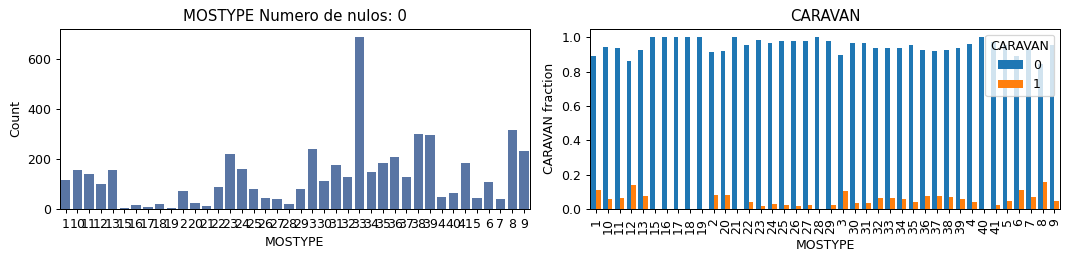

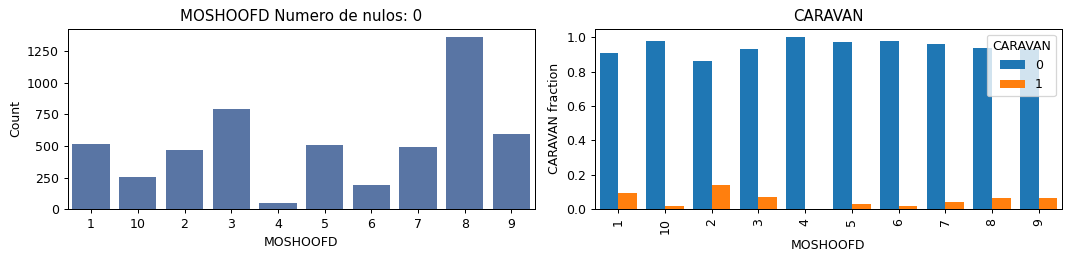

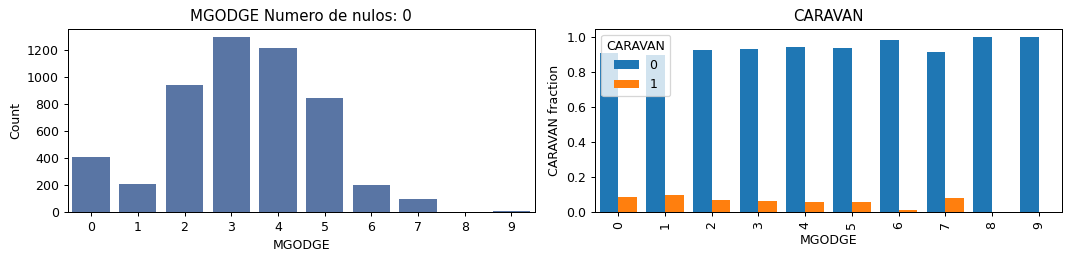

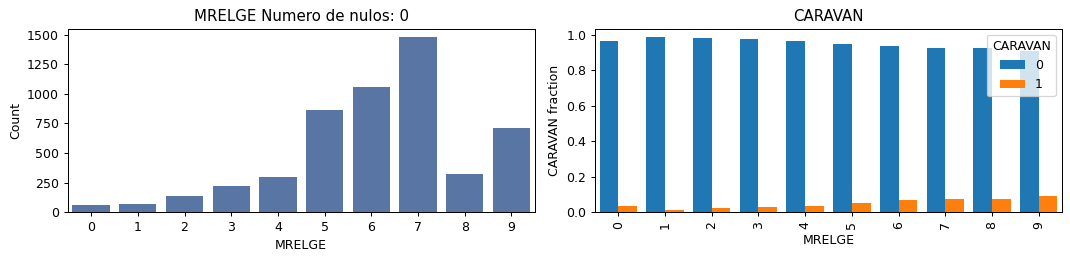

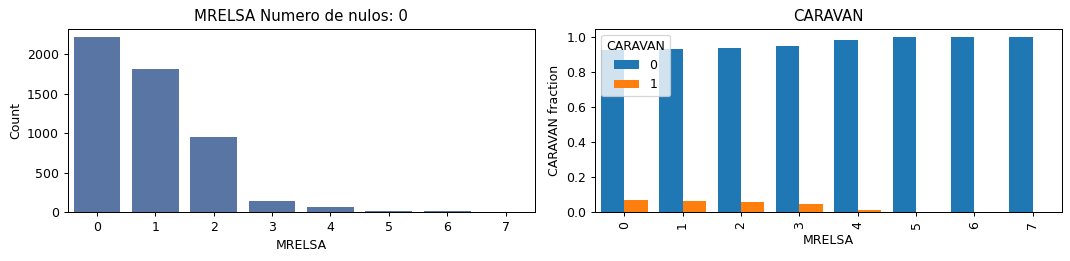

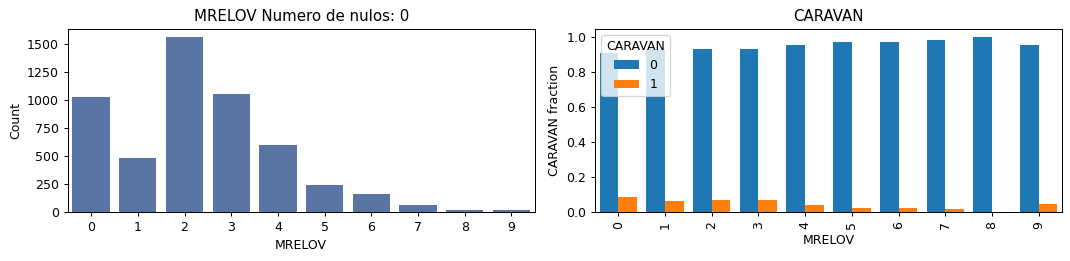

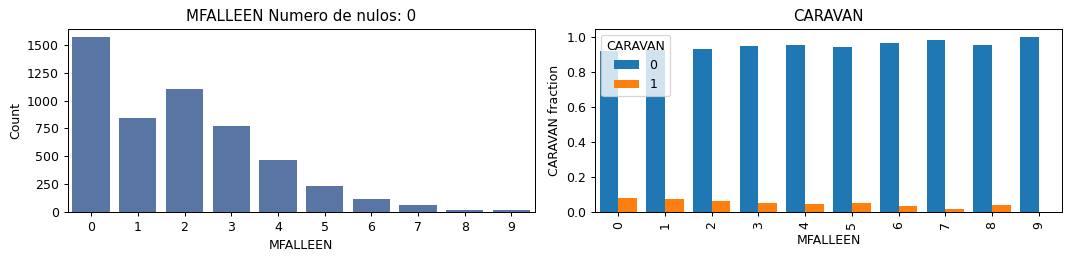

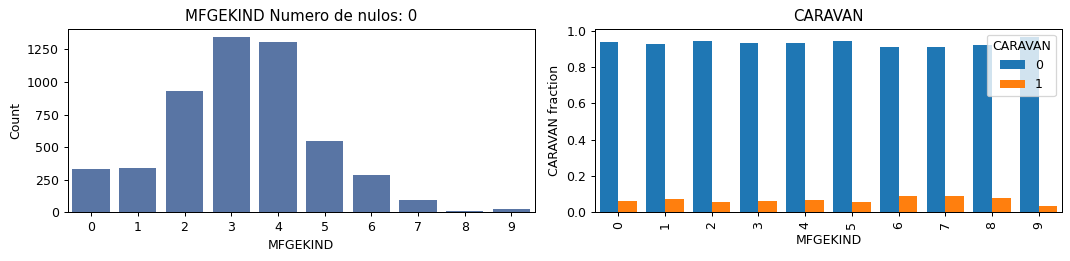

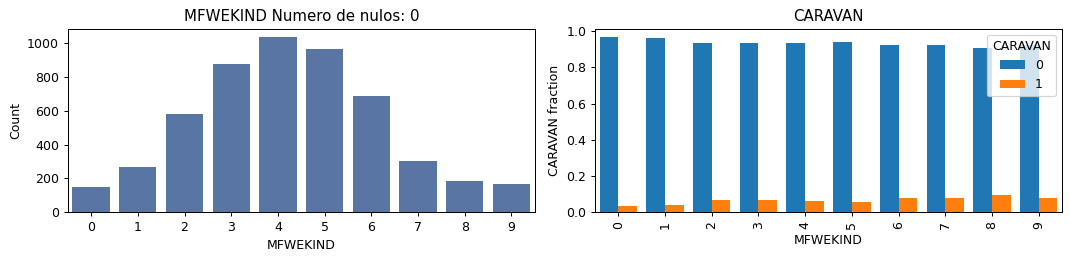

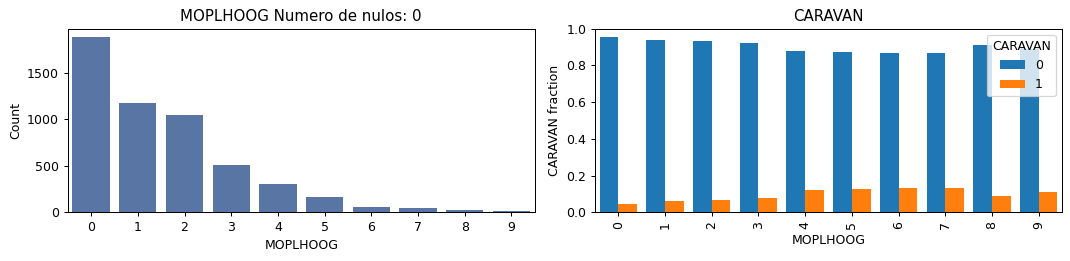

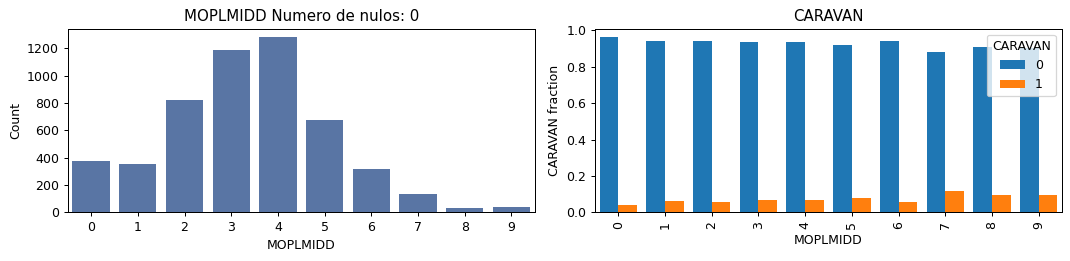

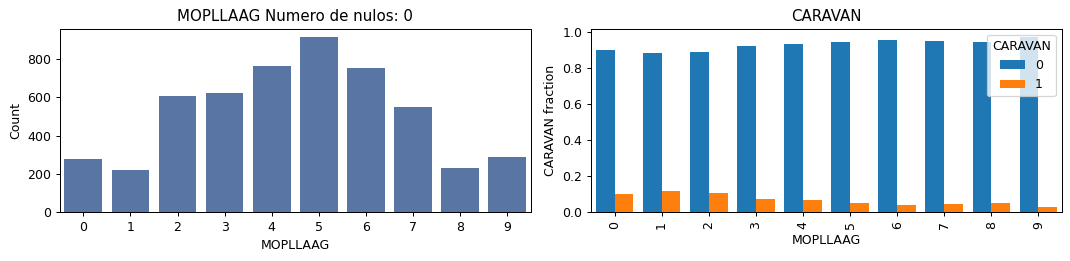

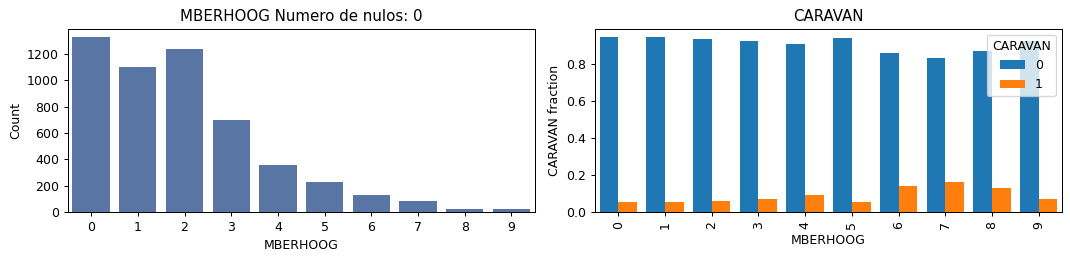

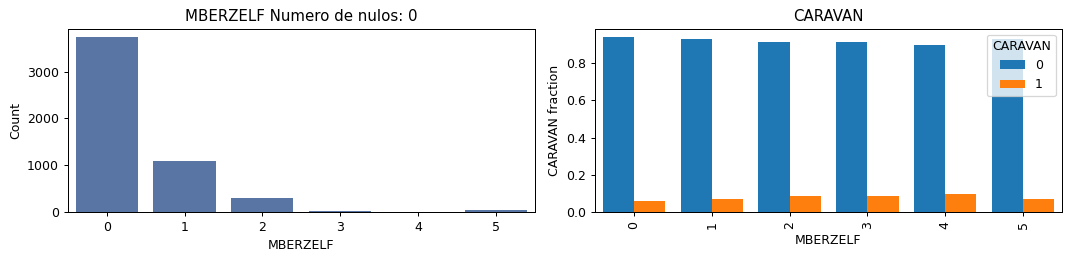

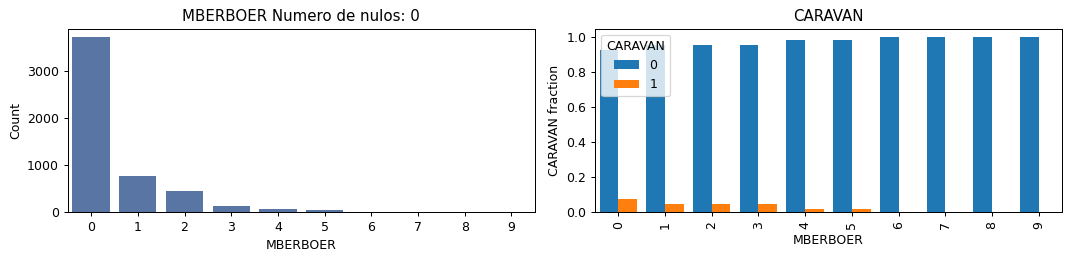

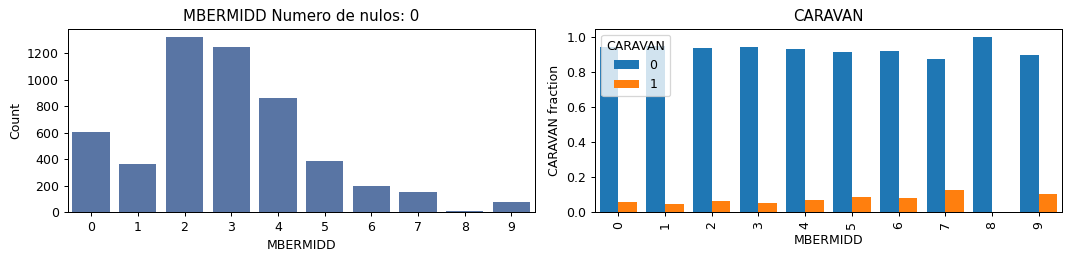

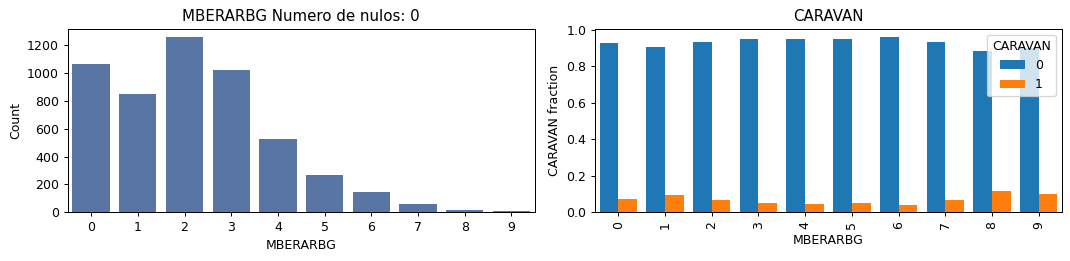

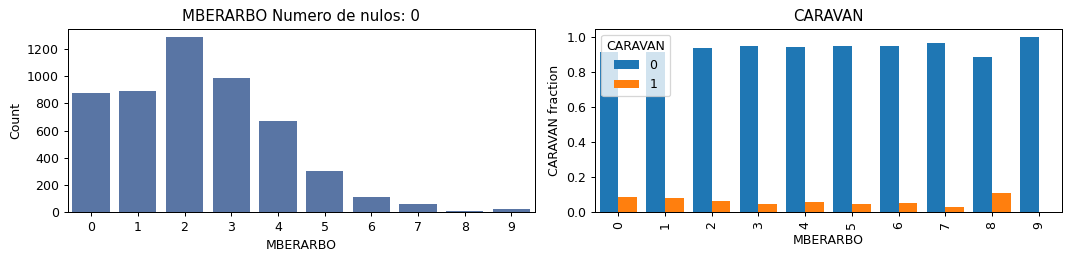

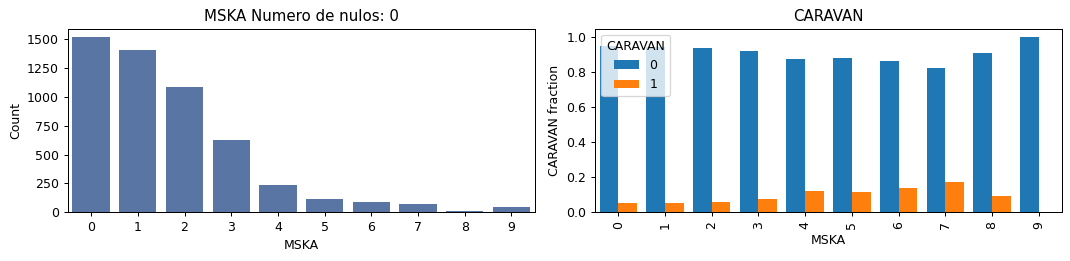

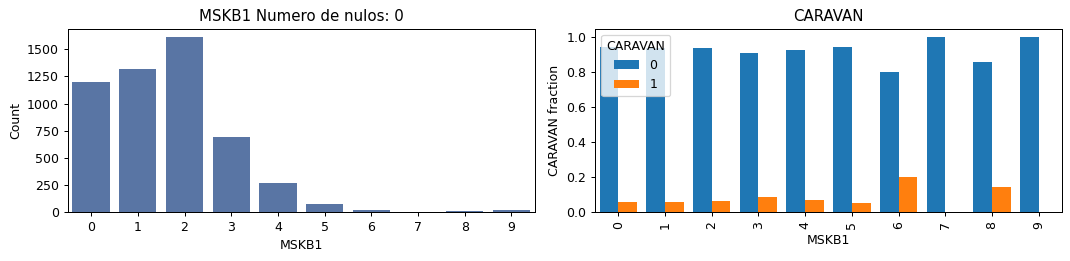

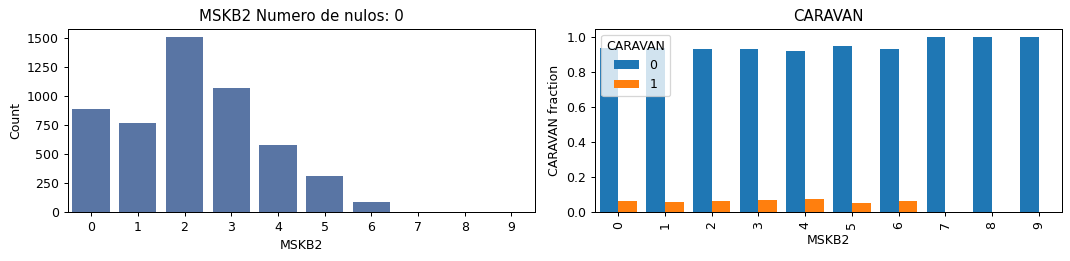

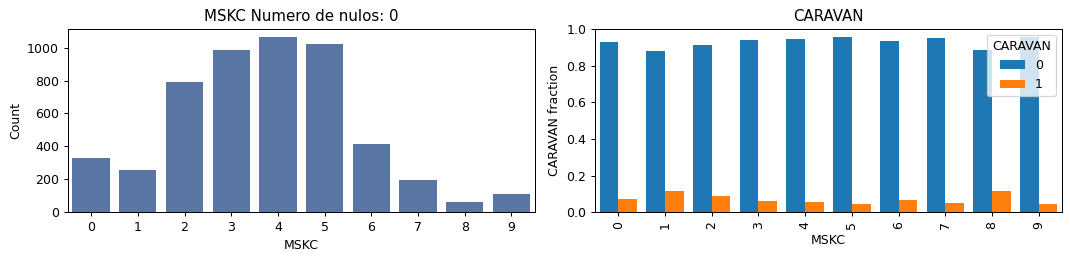

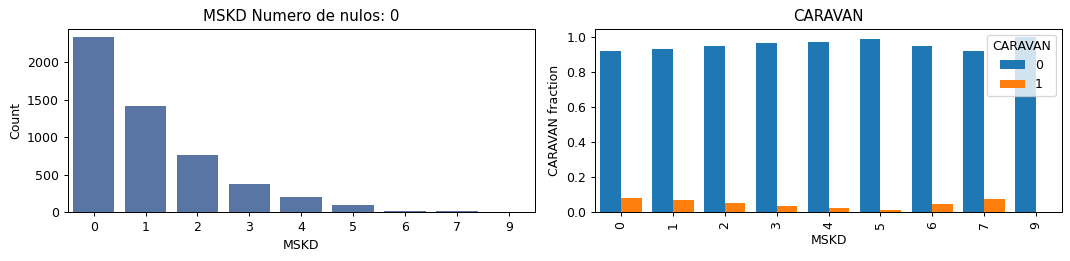

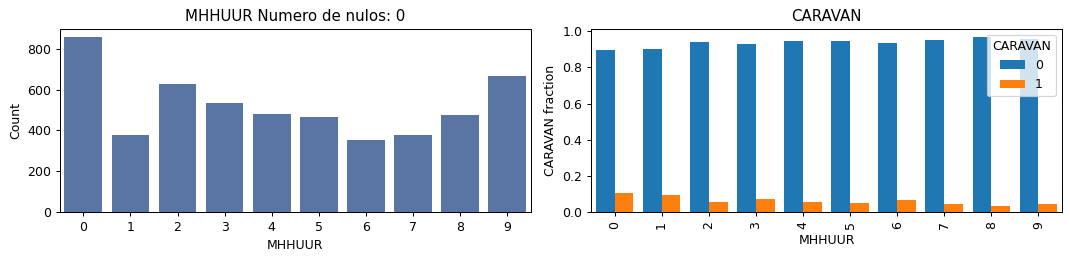

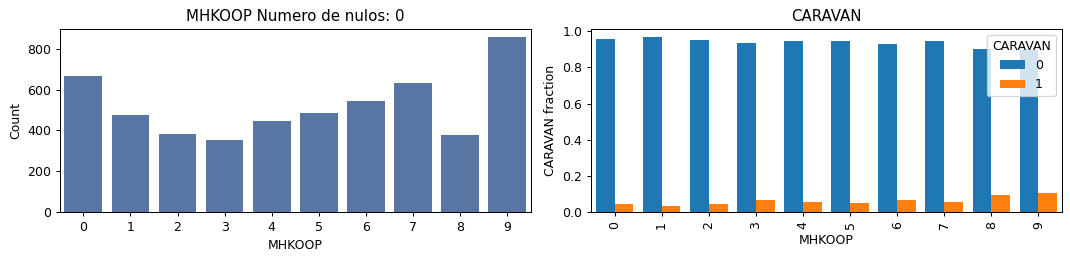

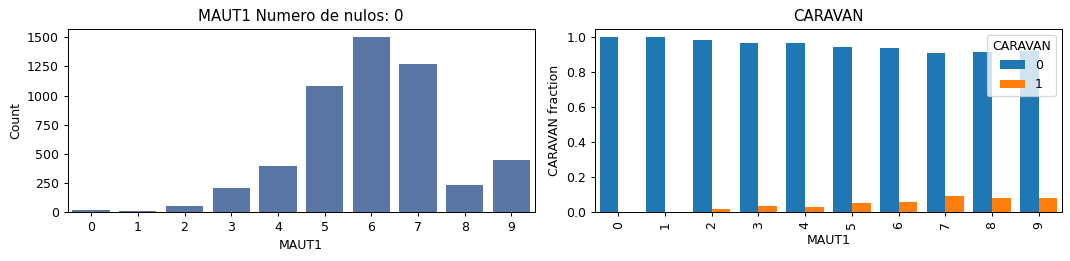

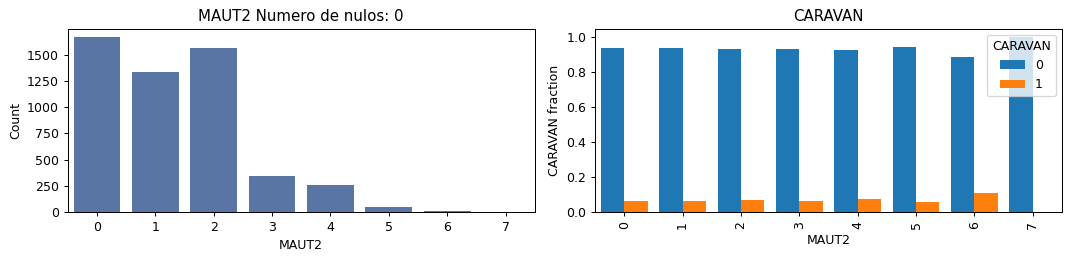

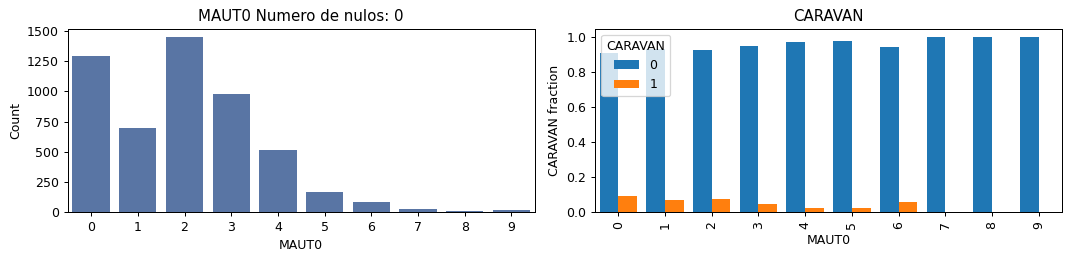

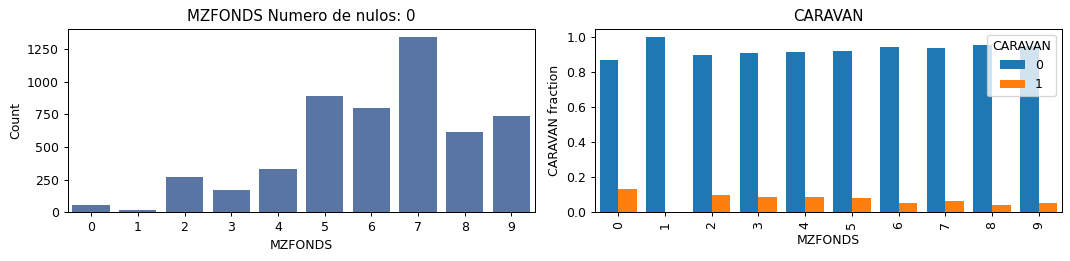

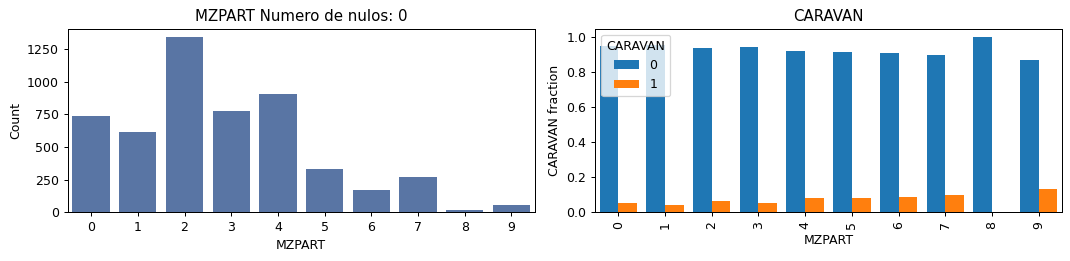

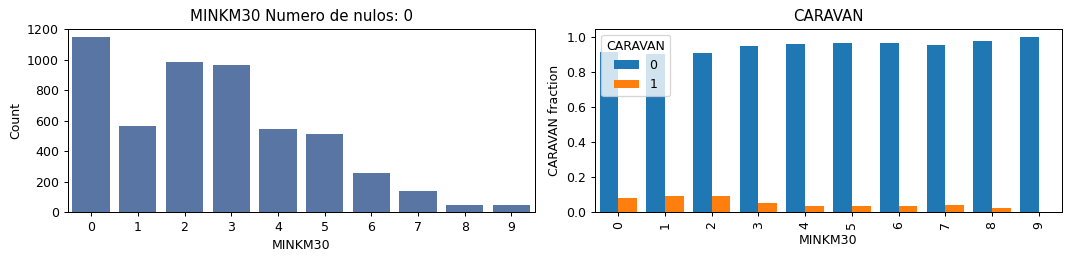

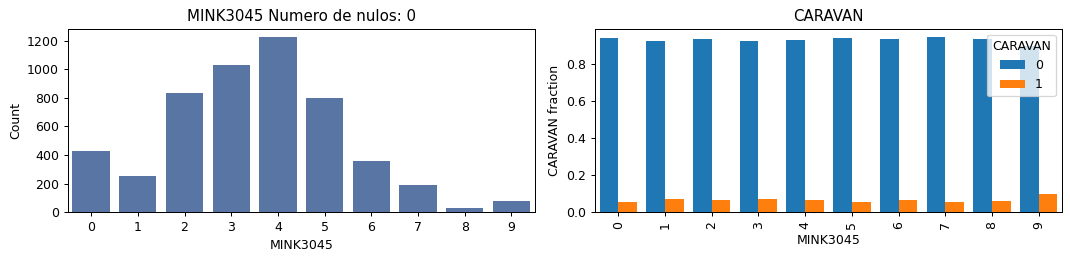

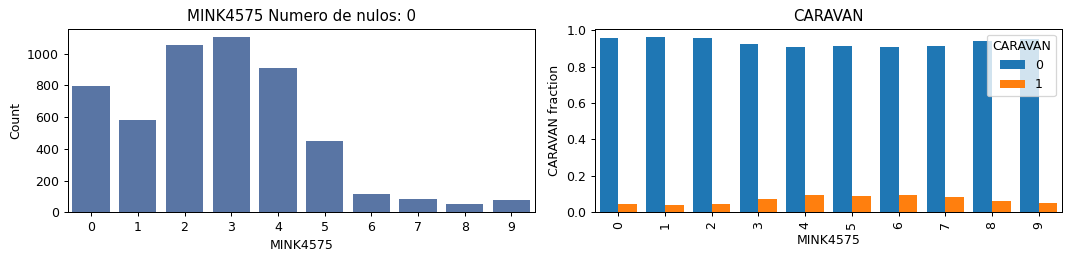

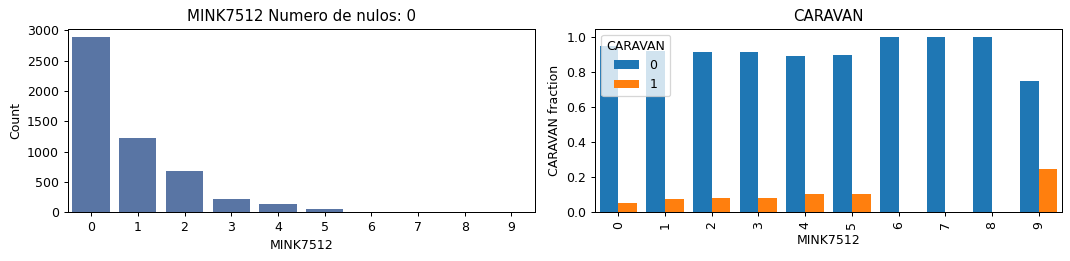

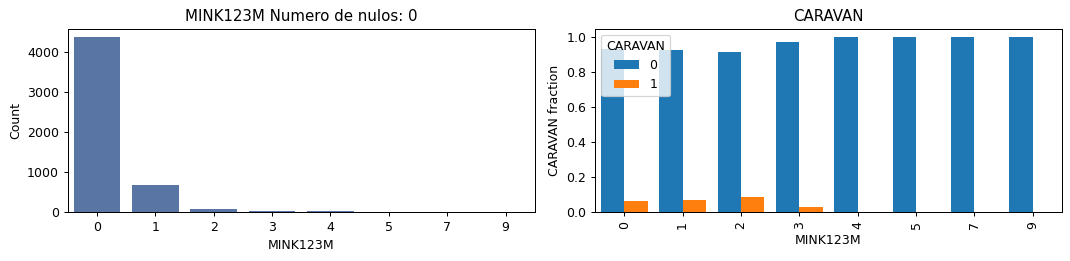

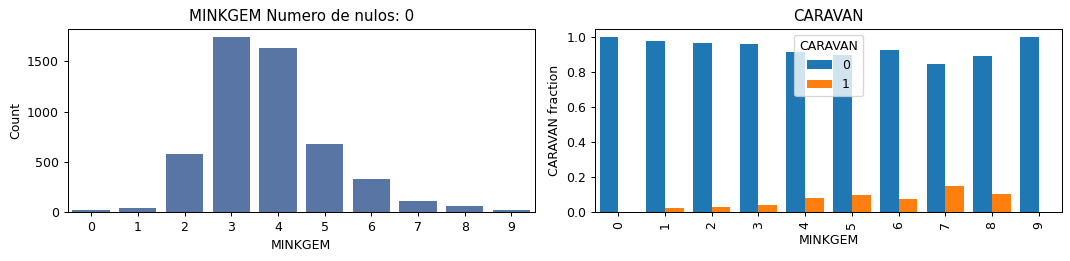

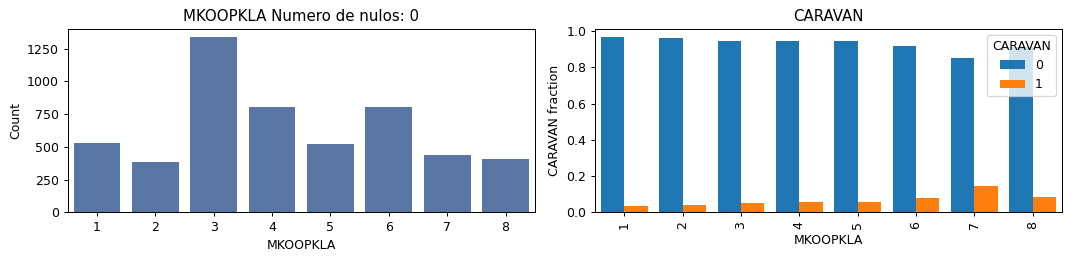

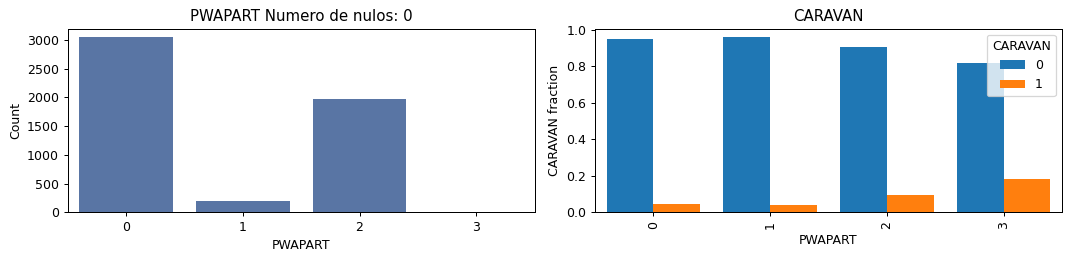

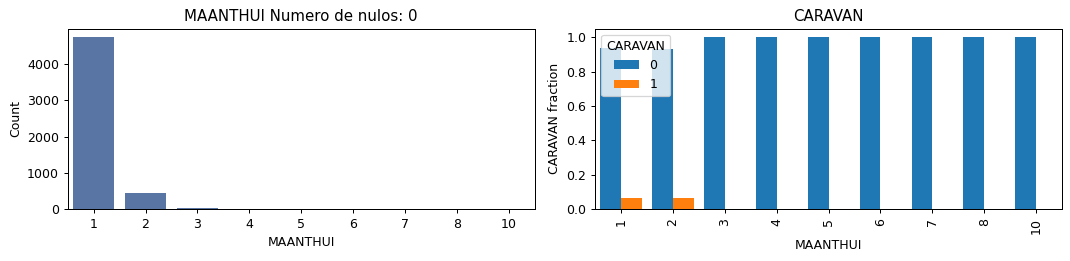

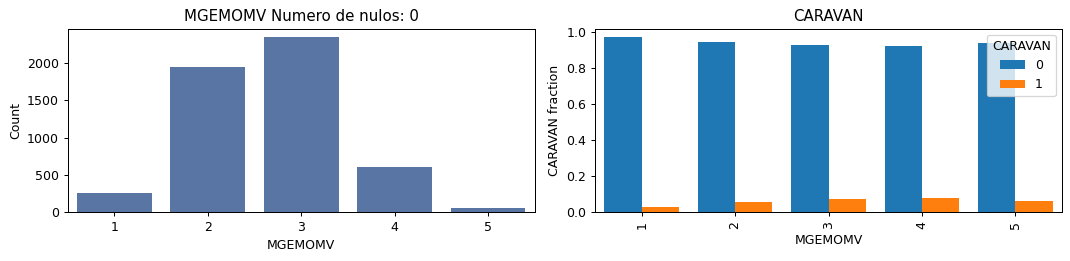

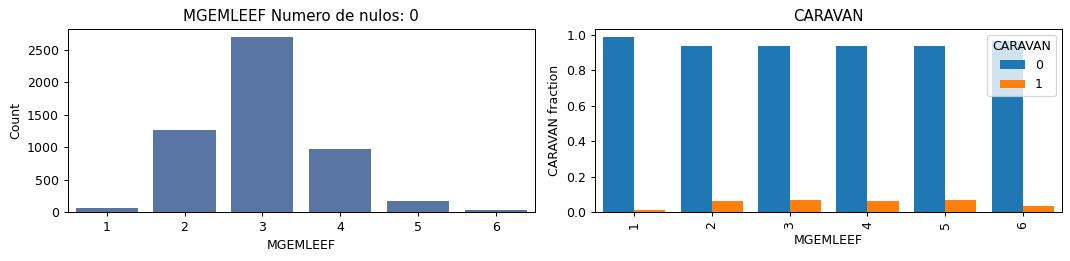

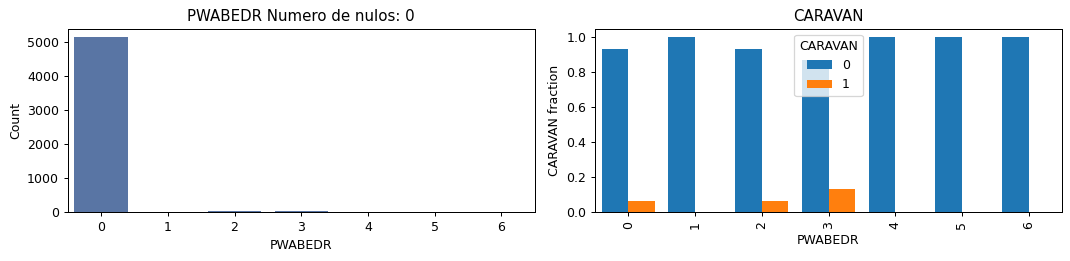

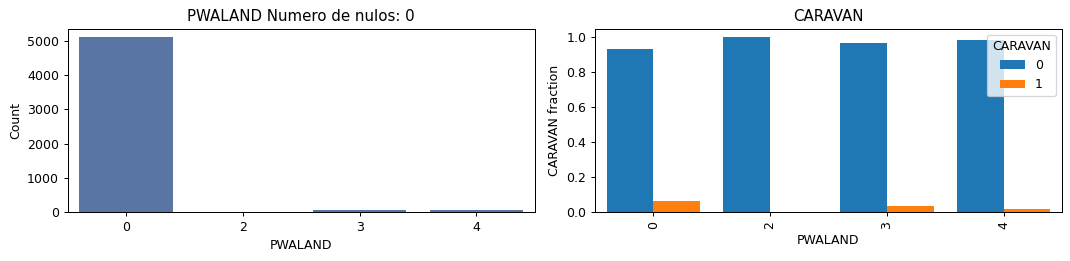

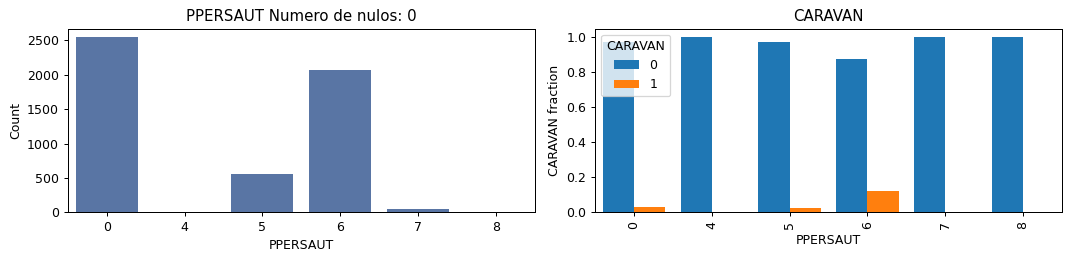

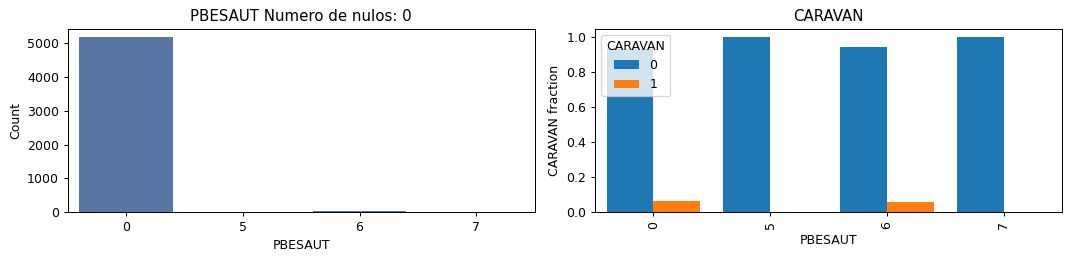

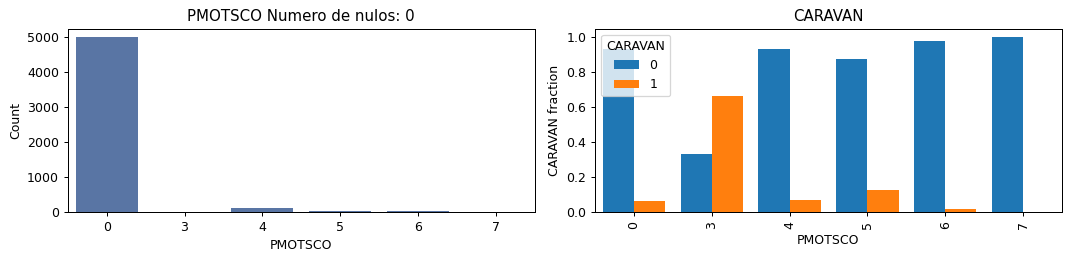

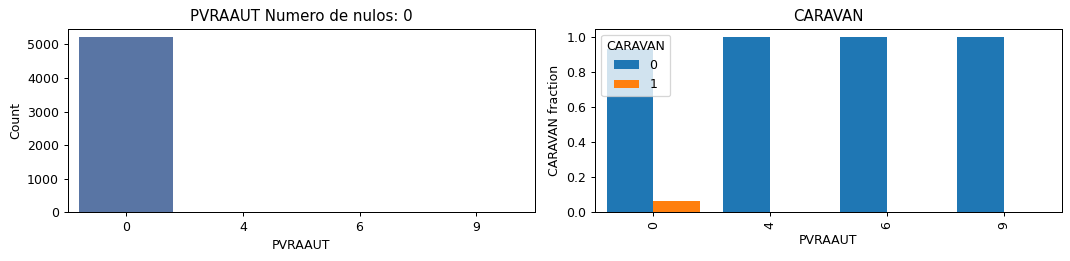

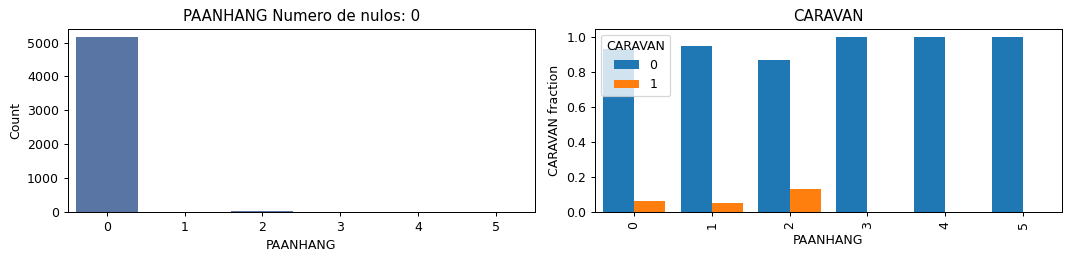

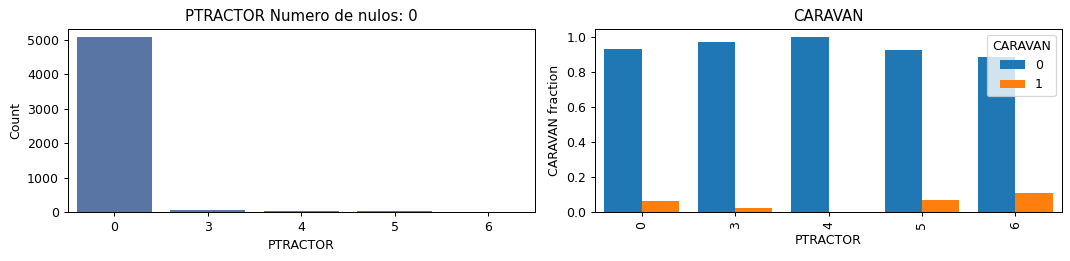

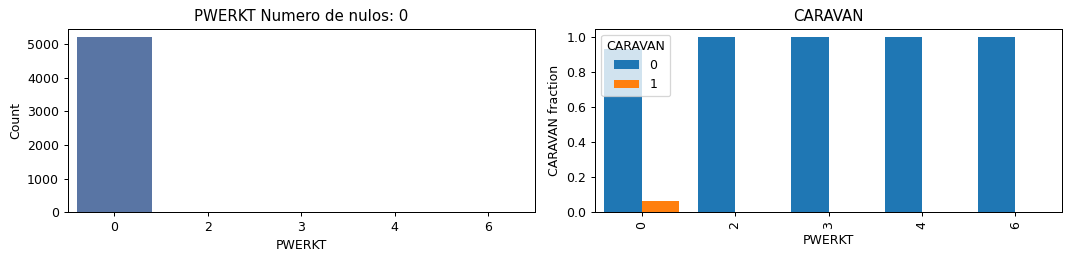

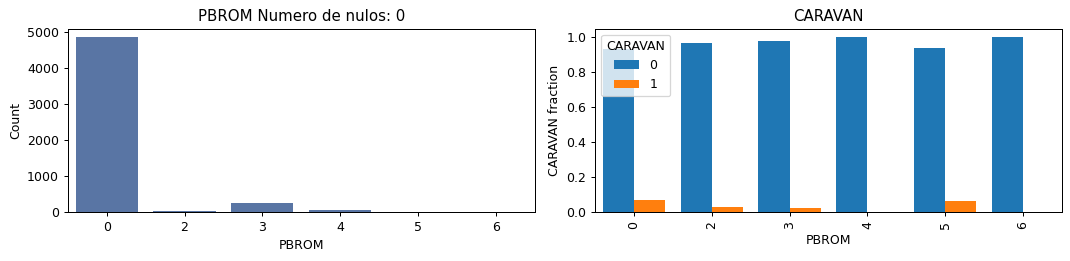

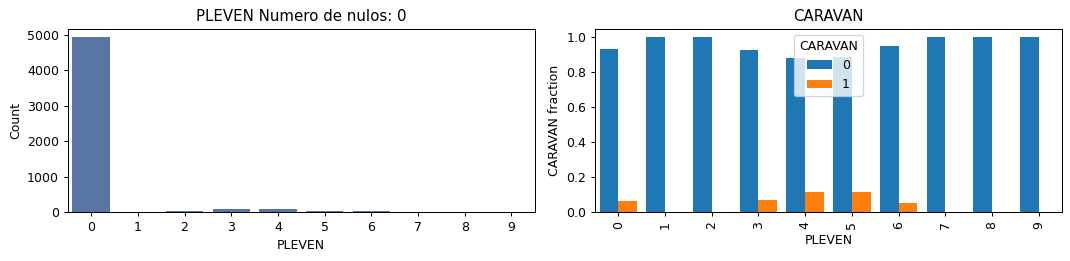

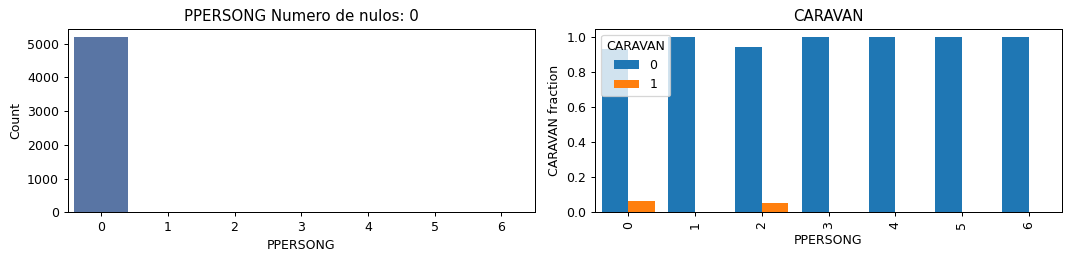

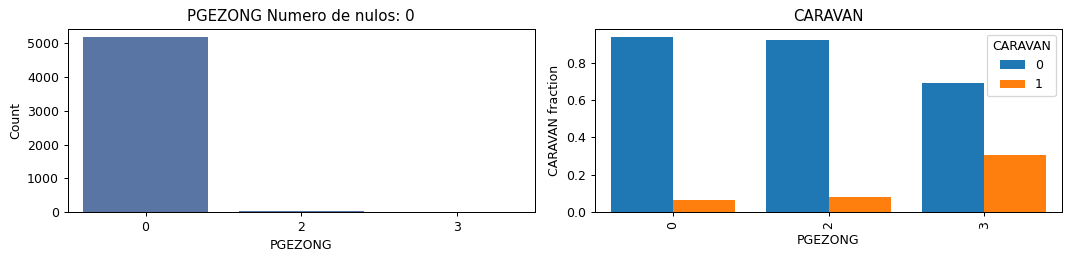

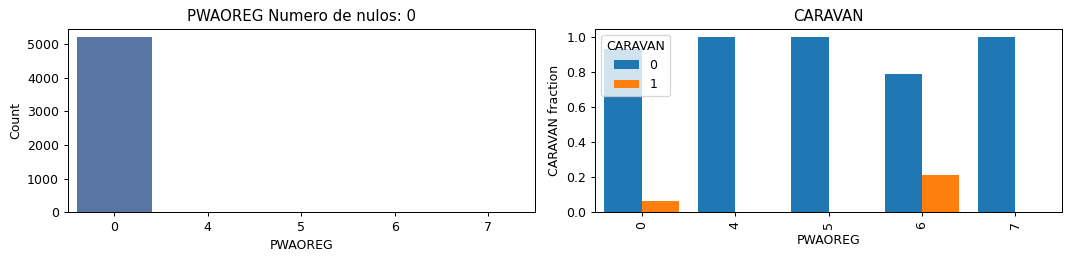

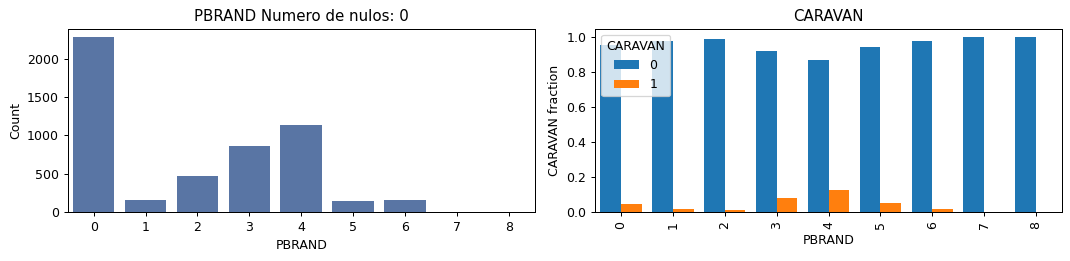

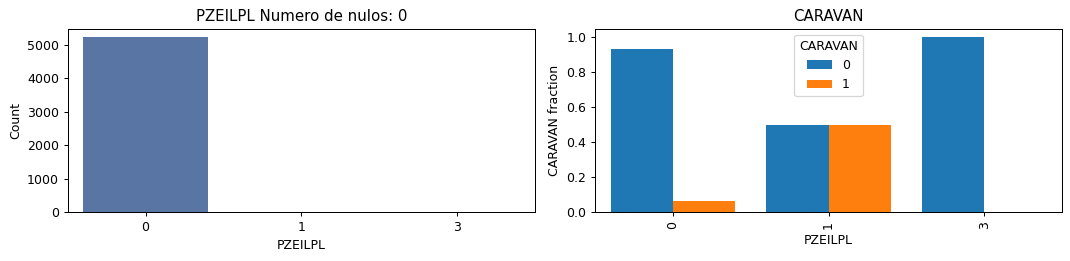

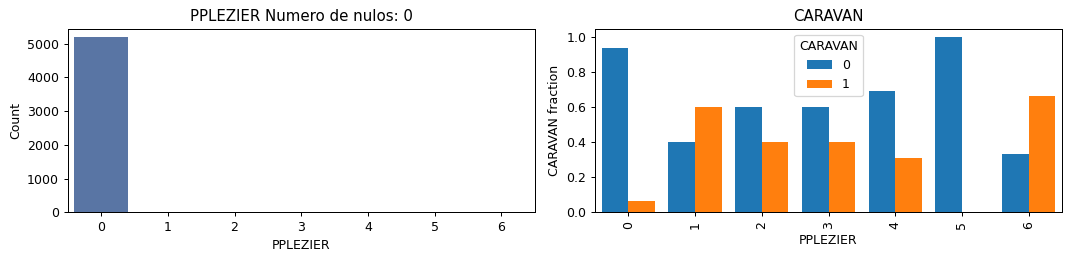

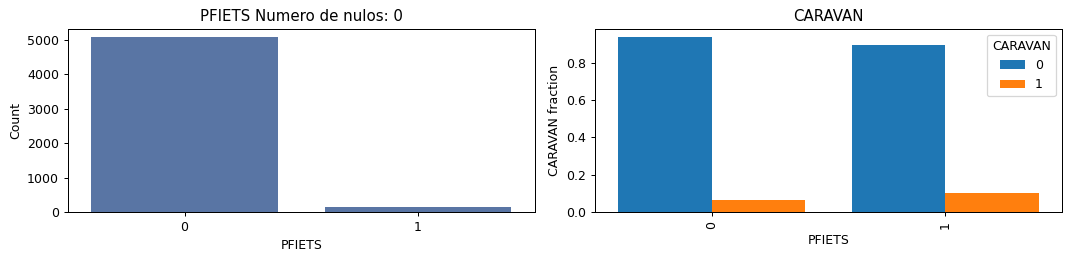

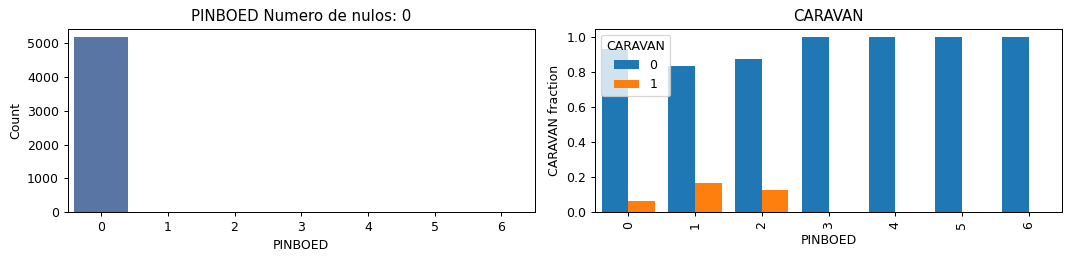

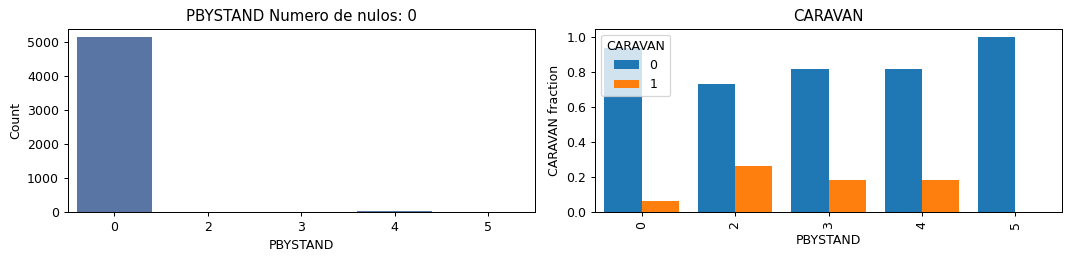

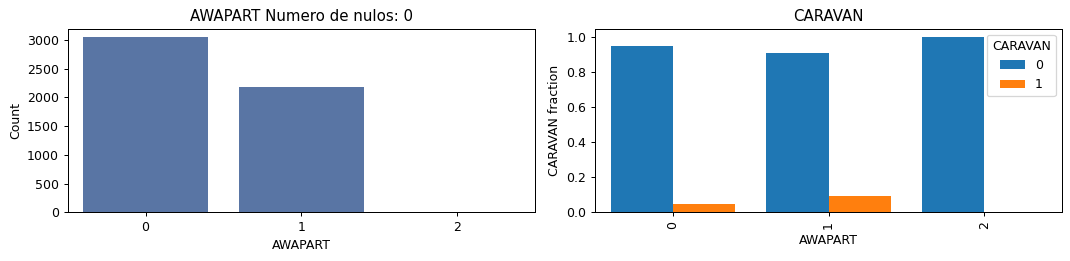

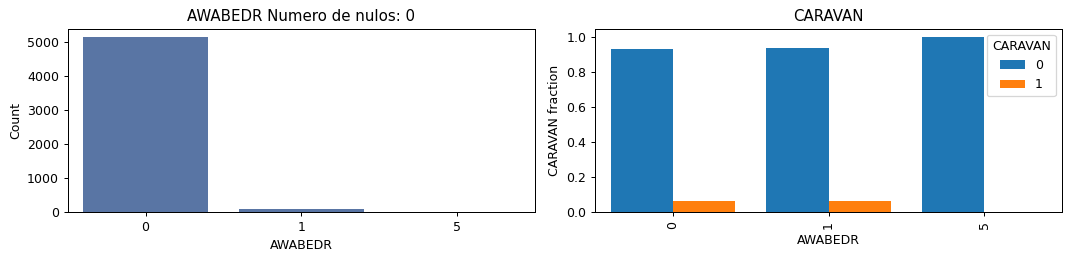

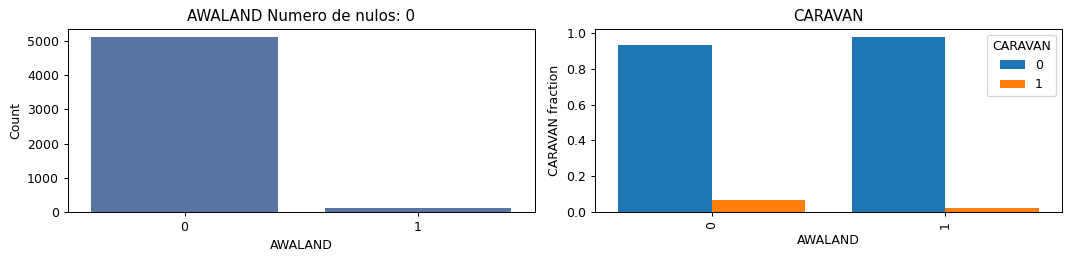

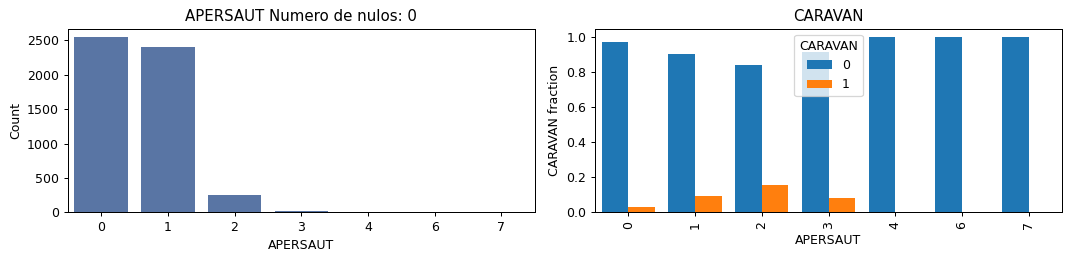

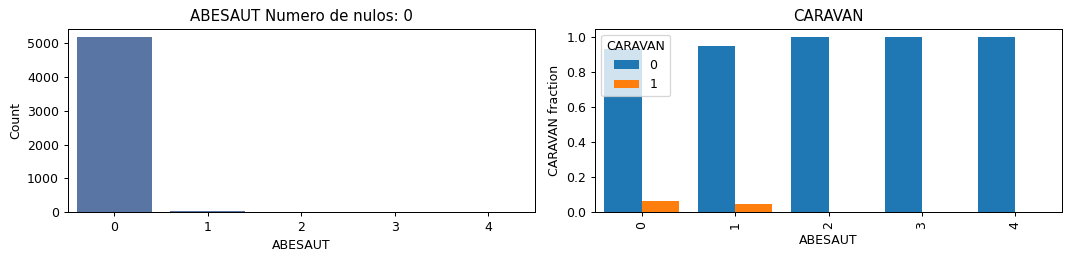

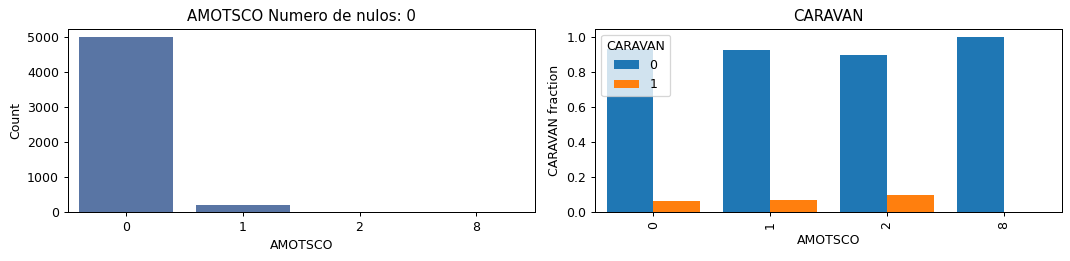

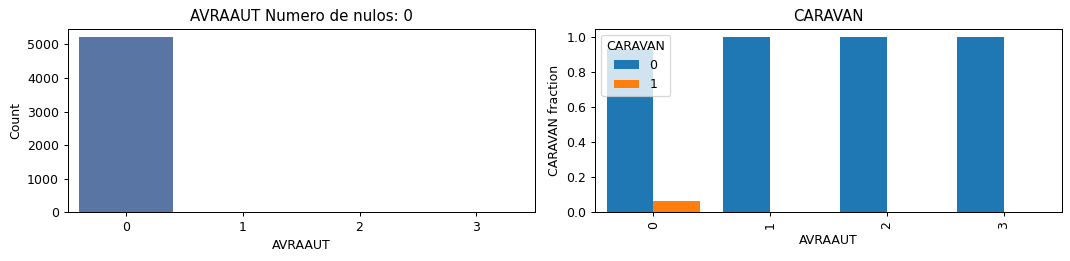

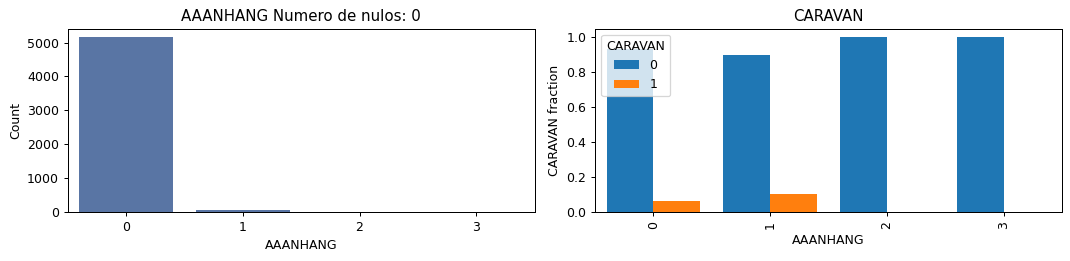

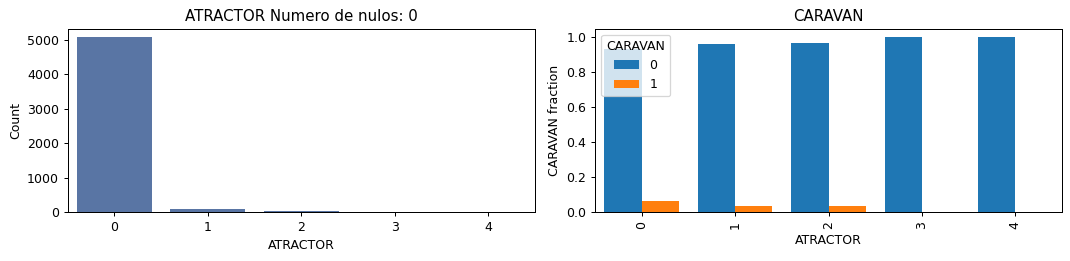

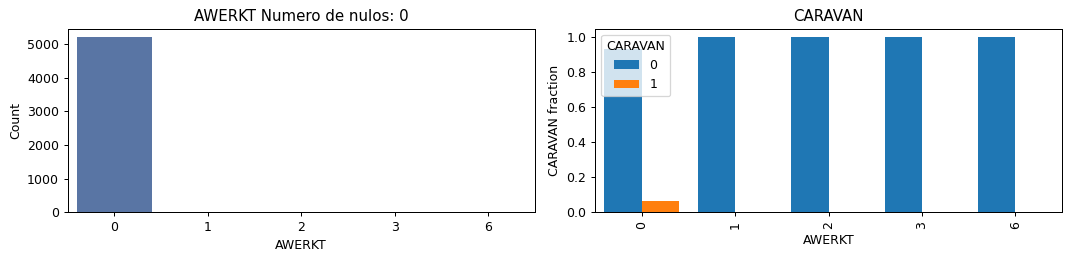

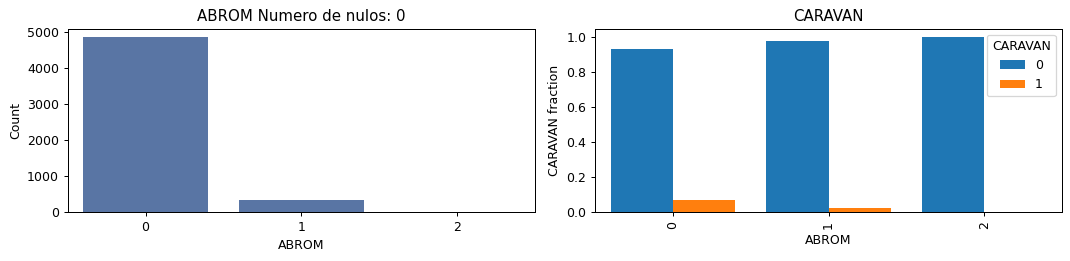

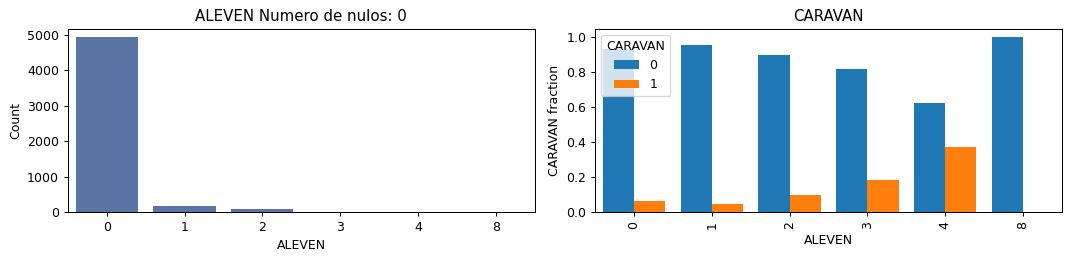

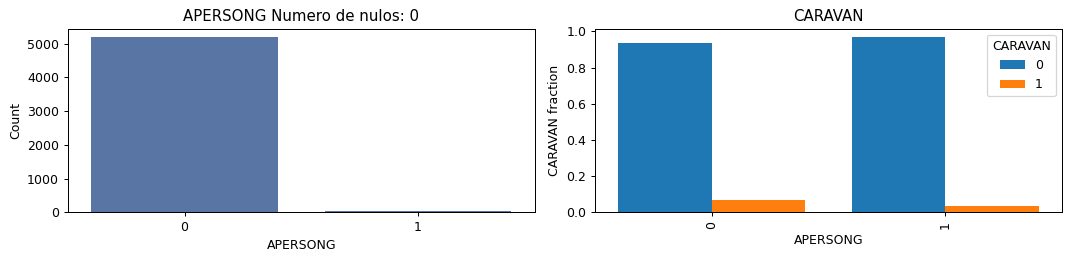

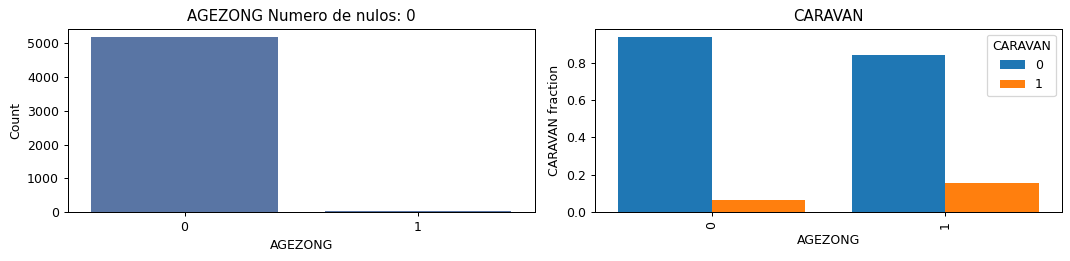

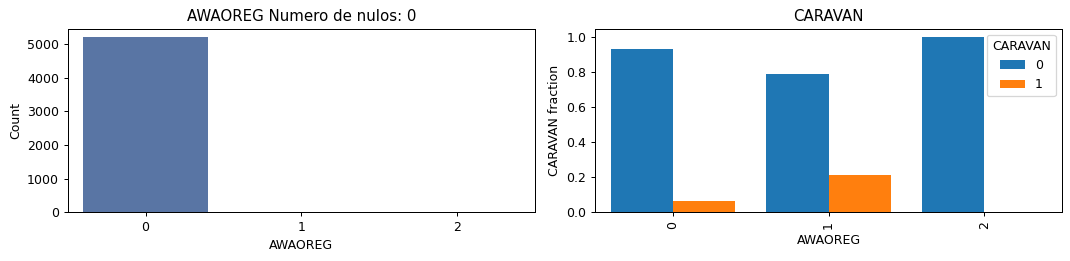

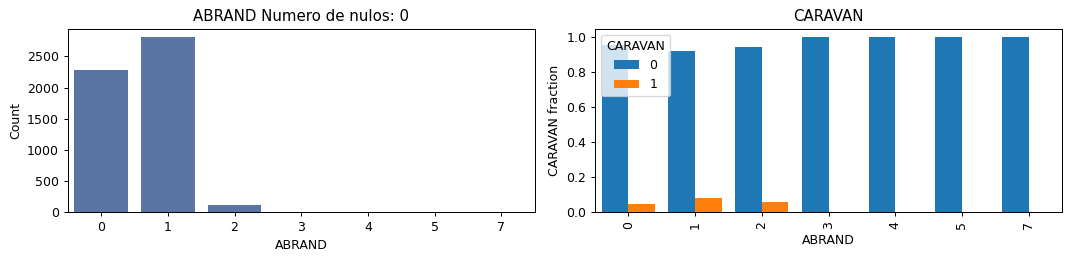

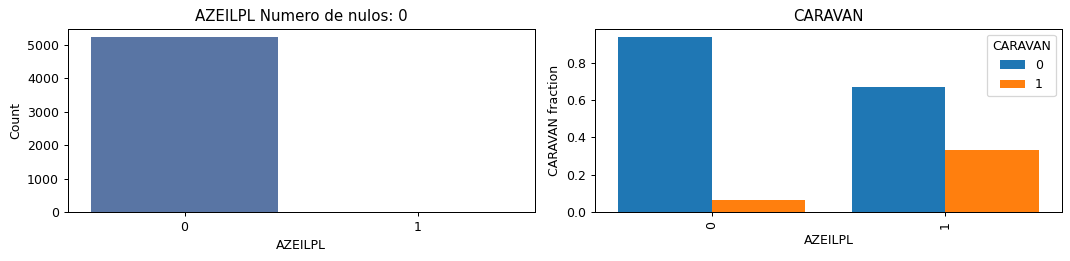

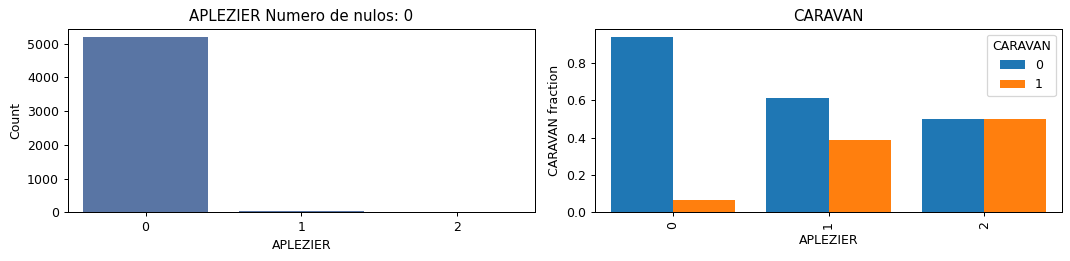

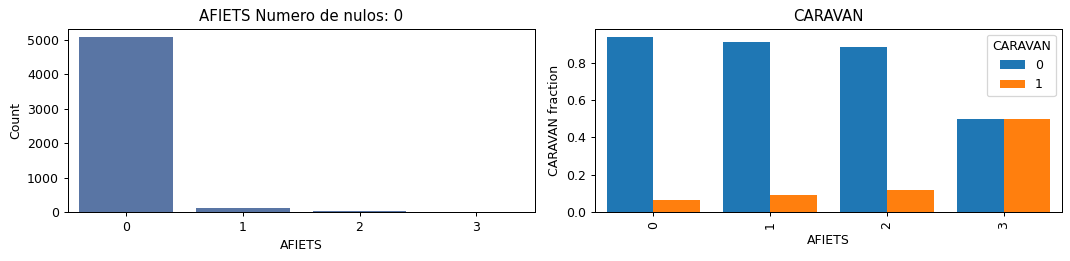

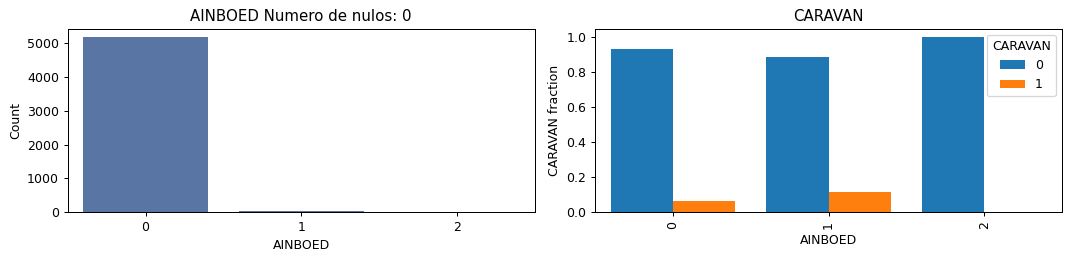

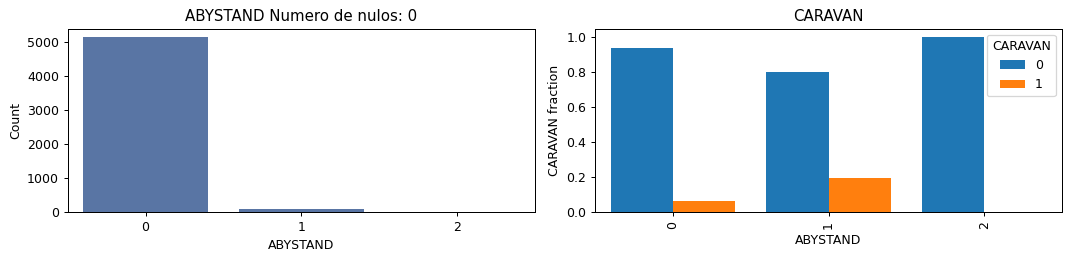

In [18]:
warnings.filterwarnings('ignore')

for i in list(pd_data.columns):
    if (pd_data[i].dtype==float) & (i!='CARAVAN'):
         plot_feature(pd_data, col_name=i, isContinuous=True, target='CARAVAN')
    elif  i!='CARAVAN':
        plot_feature(pd_data, col_name=i, isContinuous=False, target='CARAVAN')

- Hemos decidido solo tener el tipo de visualizacion en manera de columnas debido a que los datos a manejar, por ser continuos y por la manera en que estaban mal balanceados la variable objetivo, no era factible la visualizacion en un grafico de caja y bigote. Por tanto solo se tomo en cuenta el tipo de visualizacion en grafico de columnas

- De los datos mostrados se pueden hacer algunas inferencias sobre como la variable objetivo se comporta en relacion a las variables independientes. Alguno de las inferencias son:
    1. El numero de personas que contribuyo 1 - 49 en las polizas de seguro para surfear (PZEILPL) fueron la mayoria de lo que compraron polizas de seguro para caravanas por tanto es una variabe importante a tener en consideracion al momento del analizis de ML.
    2. Ninguna persona que compro una poliza de seguro para camiones ha coprado una poliza de seguro para caravanas (AVRAAUT) por tanto tambien constituye en una variable clave de nuestro analisis
    3. La mayoria de individuos que compraron un seguro de caravana han pagado 4 seguro de vida (ALEVEN)
   
   
- Esta manera de visualizacion permite tener un entendimiento de cuales son alguda de las variables que mas influyen en nuestra variable objetivo que es la compra de seguros para caravanas

# Visualizacion de Outliers

In [19]:
list_variables_categoricas, other = dame_variables_categoricas(dataset=pd_data)
pd_data[list_variables_categoricas] = pd_data[list_variables_categoricas].astype("category")
list_variables_numericas = list(pd_data.select_dtypes("int").columns)
pd_data[list_variables_numericas] = pd_data[list_variables_numericas].astype(int)
pd_data.dtypes

MOSTYPE     category
MOSHOOFD    category
MGODGE      category
MRELGE      category
MRELSA      category
MRELOV      category
MFALLEEN    category
MFGEKIND    category
MFWEKIND    category
MOPLHOOG    category
MOPLMIDD    category
MOPLLAAG    category
MBERHOOG    category
MBERZELF    category
MBERBOER    category
MBERMIDD    category
MBERARBG    category
MBERARBO    category
MSKA        category
MSKB1       category
MSKB2       category
MSKC        category
MSKD        category
MHHUUR      category
MHKOOP      category
MAUT1       category
MAUT2       category
MAUT0       category
MZFONDS     category
MZPART      category
MINKM30     category
MINK3045    category
MINK4575    category
MINK7512    category
MINK123M    category
MINKGEM     category
MKOOPKLA    category
PWAPART     category
CARAVAN     category
MAANTHUI       int32
MGEMOMV        int32
MGEMLEEF       int32
PWABEDR        int32
PWALAND        int32
PPERSAUT       int32
PBESAUT        int32
PMOTSCO        int32
PVRAAUT      

In [20]:
get_deviation_of_mean_perc(pd_data, list_variables_numericas, target='CARAVAN', multiplier=3)

0         1  variable sum_outlier_values porcentaje_sum_null_values
           0         1                                                        
0        1.0       0.0  MAANTHUI                 44                   0.008429
1   0.964286  0.035714  MGEMLEEF                 28                   0.005364
2   0.933333  0.066667   PWABEDR                 75                   0.014368
3      0.975     0.025   PWALAND                120                   0.022989
4   0.958333  0.041667   PBESAUT                 48                   0.009195
5   0.935484  0.064516   PMOTSCO                217                   0.041571
6        1.0       0.0   PVRAAUT                  9                   0.001724
7   0.907692  0.092308  PAANHANG                 65                   0.012452
8   0.965035  0.034965  PTRACTOR                143                   0.027395
9        1.0       0.0    PWERKT                 21                   0.004023
10  0.978593  0.021407     PBROM                327                   0.062644
11  0.901163  0.098837    PLEVEN                172                   0.032950
12  0.967742  0.032258  PPERSONG                 31                   0.005939
13  0.842105  0.157895   PGEZONG                 38                   0.007280
14  0.826087  0.173913   PWAOREG                 23                   0.004406
15       1.0       0.0    PBRAND                  1                   0.000192
16  0.666667  0.333333   PZEILPL                  3                   0.000575
17  0.606061  0.393939  PPLEZIER                 33                   0.006322
18  0.896552  0.103448    PFIETS                145                   0.027778
19  0.888889  0.111111   PINBOED                 45                   0.008621
20  0.804878  0.195122  PBYSTAND                 82                   0.015709
21       1.0       0.0   AWAPART                  6                   0.001149
22  0.939024  0.060976   AWABEDR                 82                   0.015709
23     0.975     0.025   AWALAND                120                   0.022989
24  0.947368  0.052632  APERSAUT                 19                   0.003640
25  0.958333  0.041667   ABESAUT                 48                   0.009195
26  0.927273  0.072727   AMOTSCO                220                   0.042146
27       1.0       0.0   AVRAAUT                  9                   0.001724
28  0.907692  0.092308  AAANHANG                 65                   0.012452
29  0.965035  0.034965  ATRACTOR                143                   0.027395
30       1.0       0.0    AWERKT                 21                   0.004023
31  0.977778  0.022222     ABROM                360                   0.068966
32     0.875     0.125    ALEVEN                120                   0.022989
33  0.967742  0.032258  APERSONG                 31                   0.005939
34  0.842105  0.157895   AGEZONG                 38                   0.007280
35  0.826087  0.173913   AWAOREG                 23                   0.004406
36       1.0       0.0    ABRAND                 13                   0.002490
37  0.666667  0.333333   AZEILPL                  3                   0.000575
38  0.606061  0.393939  APLEZIER                 33                   0.006322
39  0.896552  0.103448    AFIETS                145                   0.027778
40  0.888889  0.111111   AINBOED                 45                   0.008621
41  0.804878  0.195122  ABYSTAND                 82                   0.015709

- En este caso se identificaron los valores nulos pero en este paso no se eliminara ningun dato. Mas adelante al desarrollar el modelo de ML se verificara como manejar los nulos

# Verificar la correlacion de los datos numericos

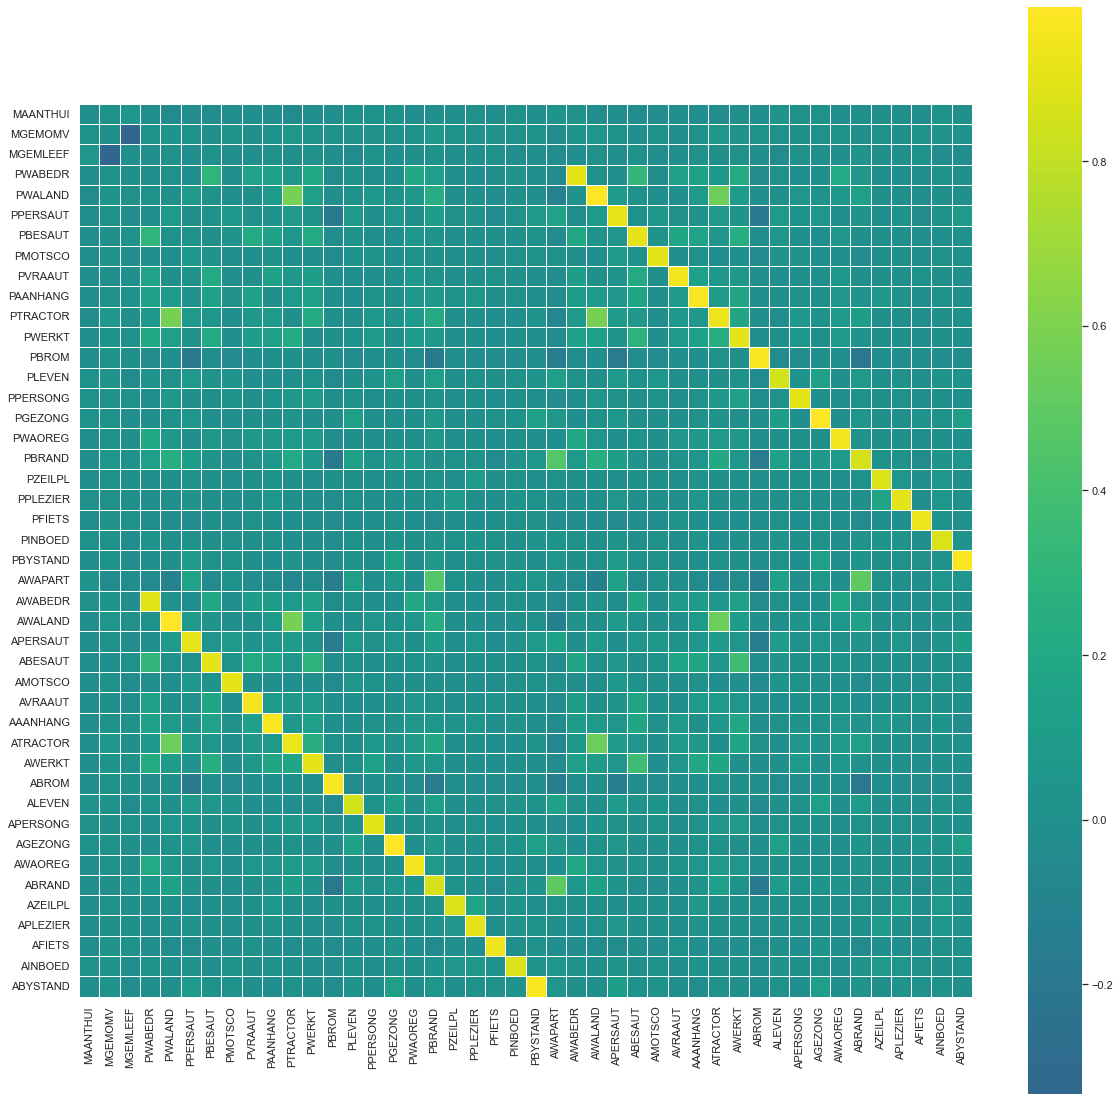

0

In [21]:
get_corr_matrix(dataset = pd_data[list_variables_numericas], 
                metodo='pearson', size_figure=[20,20])

- El analisis de la correlacion entre los datos indica que hay aproximadamente 20 variables con alta correlacion. Esto es como  debido a que dentro de nuestros datos estamos tratando con algunas variables que se expresan tanto en tipo numerico ( por ejemplo que AWABEDR el cual representa el numero de personas que compraron un third party insurrance) con otra variable muy correlacionada en significado como el rango de contribucion que fue realizado (para continuar con el ejemplo anterior el AWABEDR tinene alta correlacion con el PWABEDR que es la contribucion por una persona para poder adquirir un third party insurrance). Por tanto es necesario definir solo una variable a tratar entre todas estas variables con alta semejanza.


- Estas variables de alta correlacion deben ser verificadas para ver la factibilidad, o no, de reducir el numero de variables a introducir dentro del analisis de ML. **Pero como todavia no se sabe el modelo de machine learning a realizar, estas variables dentro del dataset no va a ser modificada.**